> Note that all files in this notebook are uploaded from private google drive. The same code can be replicated using same files from [github](https://github.com/tssorokina/information_component_of_monetary_shocks).

# Running the regressions on different instruments

In this section we define the code which will help us to maximise the $R^2$ in Step 3 by choosing parameters $\eta^{news}, \lambda^{news}, \eta^{CBR}, \lambda^{CBR}$.

We use `optuna` library to find hyperparameters of the model in Stage 2:

* $(\hat\beta^{news},\hat\alpha^{news})=\underset{\alpha^{news},\beta^{news}}{\text{argmin}}
{\|KR-
\alpha^{news}-{\beta^{news}}'X^{news}
\|}^2_2 + \lambda^{news}\eta^{news}(\|\alpha^{news}\|_1+\|\beta^{news}\|_1)
 +\lambda^{news}(1-\eta^{news})(\|\alpha^{news}\|^2_2+\|\beta^{news}\|^2_2);$

* $(\hat\beta^{CBR},\hat\alpha^{CBR})= \underset{\alpha^{CBR},\beta^{CBR}}{\text{argmin}}
{\|KR-
\alpha^{CBR}-{\beta^{CBR}}'X^{CBR}
\|}^2_2 + \lambda^{CBR}\eta^{CBR}(\|\alpha^{CBR}\|_1+\|\beta^{CBR}\|_1)
 + \lambda^{CBR}(1-\eta^{CBR})(\|\alpha^{CBR}\|^2_2+\|\beta^{CBR}\|^2_2)$

So that they would maximise the $R^2$ of the Stage 3 equation: $\Delta R_t=\zeta+\theta\Delta\mathbb{E}[KR_t]+\nu_t$ such that the regression error is null on average ($\mathbb{E}[\nu_t|\Delta\mathbb{E}[KR]]=0$).

Parameter $\theta$ here represents the effect the difference in the expectations has on the market response. For example, $\theta>0$ means that if CBR expectations are higher than the expectations of private sector, the monetary shock is positive (the prices of the government bonds rise and the real rate falls) - which would contrast the conventional theory implications of the real rate response.

The estimated value $\zeta+\theta\Delta\mathbb{E}[KR_t]$ we interpret as information component of monetary shock.

#### Initialisation

###### ❗Install packages

In [ ]:
!pip install optuna
import optuna

import statsmodels.api as sm
import pandas as pd
import numpy as np
import requests as rq
import torch
from google.colab import drive
import re
from IPython.core.display import clear_output

# for formatting
from datetime import datetime, timedelta

# for visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
clear_output()

In [ ]:
#@title ❗Import Google Drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/HSE/Project 2021'

# !unzip /content/drive/MyDrive/ML_IAD/iad-deep-learning-texts-2021.zip
# press_releases = pd.read_excel('cbr.xlsx')

Mounted at /content/drive
/content/drive/MyDrive/HSE/Project 2021


## Using Sbert embeddings

In [ ]:
#@title ❗functions
from sklearn.metrics import r2_score
import time
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from os import listdir

def fit_model(l1_ratio_news, l1_ratio_cbr, alpha_news, alpha_cbr, hf_delta, news, previews, rate):
    elastic_news = ElasticNet(alpha=alpha_news, l1_ratio=l1_ratio_news)
    elastic_news.fit(news, rate)
    preds_news = elastic_news.predict(news)

    elastic_cbr = ElasticNet(alpha=alpha_cbr, l1_ratio=l1_ratio_cbr)
    elastic_cbr.fit(previews, rate)
    preds_cbr = elastic_cbr.predict(previews)

    lr = LinearRegression()
    expectations_diff = (preds_cbr - preds_news).reshape(-1,1)
    lr.fit(expectations_diff, hf_delta)
    return elastic_news, elastic_cbr, lr, r2_score(hf_delta, lr.predict(expectations_diff))



def find_optimal_fit(delta, X_news, X_previews, y):
    scores = []

    for l1_ratio_news in np.linspace(0,1,11):
        for l1_ratio_cbr in np.linspace(0,1,11):
            for alpha_news in np.linspace(0,20,11):
                for alpha_cbr in np.linspace(0,20,11):
                    _, _, _, r2 = fit_model(l1_ratio_news, l1_ratio_cbr, alpha_news, alpha_cbr, delta, X_news, X_previews, y)

                    scores.append({'l1_ratio_news': l1_ratio_news,
                                  'l1_ratio_cbr': l1_ratio_cbr,
                                  'alpha_news': alpha_news,
                                  'alpha_cbr': alpha_cbr,
                                  'score': r2})

    new_params = sorted(scores, key=lambda x: x['score'], reverse=True)[0]
    print('Primary optimal parameters:\n', new_params)

    scores = []
    
    for l1_ratio_news in np.linspace(max(new_params['l1_ratio_news']-0.1, 0),new_params['l1_ratio_news']+0.1,11):
        for l1_ratio_cbr in np.linspace(max(new_params['l1_ratio_cbr']-0.1, 0),new_params['l1_ratio_cbr']+0.1,11):
            for alpha_news in np.linspace(max(new_params['alpha_news']-2, 0),new_params['alpha_news']+2,11):
                for alpha_cbr in np.linspace(max(new_params['alpha_cbr']-2, 0),new_params['alpha_cbr']+2,11):
                    _, _, _, r2 = fit_model(l1_ratio_news, l1_ratio_cbr, alpha_news, alpha_cbr, delta, X_news, X_previews, y)

                    scores.append({'l1_ratio_news': l1_ratio_news,
                                  'l1_ratio_cbr': l1_ratio_cbr,
                                  'alpha_news': alpha_news,
                                  'alpha_cbr': alpha_cbr,
                                  'score': r2})
                    
    params = sorted(scores, key=lambda x: x['score'], reverse=True)[0]
    news_en, cbr_en, lr, _ = fit_model(params['l1_ratio_news'], params['l1_ratio_cbr'], params['alpha_news'], params['alpha_cbr'], delta, X_news, X_previews, y)
    print('Final optimal parameters:\n', params)
    return news_en, cbr_en, lr


def save_models(news_en, cbr_en, lr):
    for model in [news_en, cbr_en, lr]:
      with open(f'model_{str(model)}.pkl', 'wb') as f:
          pickle.dump(model, f)


def draw_news_component(delta, news_component):
    dates = previews['date'].iloc[:len(delta)]
    dates = [i for i in dates.iloc[::-1]]
    
    delta = delta[::-1]
    news_component = news_component[::-1]
    plt.figure(figsize=(6, 5))
    plt.plot(dates, delta, label='delta_R')
    plt.plot(dates, news_component, label='news component')
    plt.plot(dates, delta-news_component, '--', label='pure monetary shock')
    plt.legend()
    # plt.axhline(y=0, color='grey')
    plt.ylim(-(max(max(delta), abs(min(delta)))+0.001), max(max(delta), abs(min(delta)))+0.001)
    plt.xticks(rotation=45)
    plt.grid()
    plt.title('News component of the monetary shock')
    plt.show()

 
def draw_proxy_expectations(cb_exp, news_exp, model_name, experiment_number):
    plt.figure(figsize=(18, 6), dpi=80)
    plt.plot([i.strftime("%d.%m.%Y") for i in previews['date'].iloc[::-1]], previews['rate'].iloc[::-1], label='Rate')
    plt.plot(cb_exp[::-1], label='CB Expectations')
    plt.plot(news_exp[::-1], label='Market Expectations')
    plt.title(f'ExpectationsEstimated with {model_name}')
    plt.xlabel('Date', color='gray')
    plt.ylabel('Rate, %',color='gray')
    plt.legend()
    plt.xticks(rotation=45)
    now = datetime.now()
    plt.savefig(f'experiment_{experiment_number}_{model_name}_{now.day}_{now.month}.png')
    plt.show()

def get_delta(name):
    delta = pd.DataFrame(columns=['date', 'release_time', 'ten_mins_before', 'ten_mins_after', 'fifteen_mins_after', 'twenty_mins_after'])
    for filename in listdir(f'/content/drive/MyDrive/HSE/Project 2021/Prices/{name}'):
        df = pd.read_csv(f'/content/drive/MyDrive/HSE/Project 2021/Prices/{name}/{filename}', ';')
        df['date'] = [0]*len(df)
        for i in range(len(df)):
            df['date'][i] = datetime(int('20'+df['<DATE>'][i][-2:]),
                                              int(df['<DATE>'][i][3:5]),
                                              int(df['<DATE>'][i][:2]),
                                              int(df['<TIME>'][i][:2]),
                                              int(df['<TIME>'][i][3:5]),
                                              int(df['<TIME>'][i][6:])
                                              )
        day_of_preview = datetime(df['date'][len(df)-1].year, df['date'][len(df)-1].month, df['date'][len(df)-1].day)
        date_time_of_preview = previews[(previews['date'] > day_of_preview-timedelta(days=1)) * (previews['date'] < day_of_preview+timedelta(days=1))].iloc[0]['date'] + timedelta(minutes=1) # because the time of the candle, presented in the dataframe is the close time 
        # print(date_time_of_preview)
        try:
            delta = delta.append({'date': date_time_of_preview-timedelta(minutes=1),
                                  'release_time': df[df['date'] <= date_time_of_preview]['<OPEN>'].iloc[-1],
                                  'ten_mins_before': df[df['date'] <= date_time_of_preview-timedelta(minutes=10)]['<OPEN>'].iloc[-1],
                                  'ten_mins_after': df[df['date'] >= date_time_of_preview+timedelta(minutes=10)]['<OPEN>'].iloc[0],
                                  'fifteen_mins_after': df[df['date'] >= date_time_of_preview+timedelta(minutes=15)]['<OPEN>'].iloc[0],
                                  'twenty_mins_after': df[df['date'] >= date_time_of_preview+timedelta(minutes=20)]['<OPEN>'].iloc[0]
                                    }, ignore_index=True)
        except:
            new_time = df[df['date'] > date_time_of_preview]['date'].iloc[0]
            delta = delta.append({'date': new_time-timedelta(minutes=1),
                                  'release_time': df[df['date'] == new_time]['<OPEN>'].iloc[0],
                                  'ten_mins_before': df[df['date'] == new_time]['<OPEN>'].iloc[0], # seeing that on 15 december 2014 the release was posted at 00:28, we will not include any 10 mins before here.
                                  'ten_mins_after': df[df['date'] == new_time+timedelta(minutes=10)]['<OPEN>'].iloc[0],
                                  # 'fifteen_mins_after': df[df['date'] == new_time+timedelta(minutes=15)]['<OPEN>'].iloc[0],
                                  'fifteen_mins_after': -100,
                                  'twenty_mins_after': df[df['date'] == new_time+timedelta(minutes=20)]['<OPEN>'].iloc[0]
                                    }, ignore_index=True)
    return delta

import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [ ]:
# hyperparameter optimization using optuna library
def objective(trial):
    l1_ratio_news = trial.suggest_float('l1_ratio_news', 0, 1)
    l1_ratio_cbr = trial.suggest_float('l1_ratio_cbr', 0, 1)
    alpha_news = trial.suggest_float('alpha_news', 0, 10)
    alpha_cbr = trial.suggest_float('alpha_cbr', 0, 10)
    elnet_news = ElasticNet(l1_ratio=l1_ratio_news, alpha=alpha_news).fit(X_news, y)
    elnet_releases = ElasticNet(l1_ratio=l1_ratio_cbr, alpha=alpha_cbr).fit(X_previews, y)

    delta_E = (elnet_news.predict(X_news) - elnet_releases.predict(X_previews)).reshape(-1,1)
    X = sm.add_constant(delta_E)

    results = sm.OLS(delta, X).fit()
    # results = sm.OLS(delta, delta_E).fit()
    return  results.rsquared

In [ ]:
#❗Getting the pretrained embeddings
previews = pd.read_excel('./cbr_previews.xlsx').drop('Unnamed: 0', axis=1)

# the embeddings were already made
news_embeddings = torch.load('./news_rbc_13062022_sbert.pt')
previews_embeddings = torch.load('./cb_1306022_sbert.pt')

### OFZ futures

The problem of this instrument is that the data is available only with a daily frequency (or more - up to 5 days because of the gaps in data). Therefore, there is a lot of space for endogeneity.

The price in the dataset is presented for the end of the day. We suppose that if the monetary shock is present, then there was at least one transaction at the day of press-release. Then we will construct an instrument as:

$$s_t=\frac{p_{t,\tau}-p_{t,\tau-1}}{p_{t,\tau-1}}$$

Here: $s_t$ - is an instrument for a monetary shock; $p_{t,\tau}$ - the price of the chosen instrument by the end of the press release day $t$; $p_{t,\tau-1}$ - the price of the chosen instrument after teh last transaction before the press release day $t$.

In [ ]:
#@markdown Original code for delta construction. To recreate further computations it will be sufficient to import `.csv` file from github (implemented in the last line).

# deltas_for_futures = pd.DataFrame(columns=['date', 
#                                            'ofz2', 'ofz2_previous', 'delta_ofz2',
#                                            'ofz4', 'ofz4_previous', 'delta_ofz4',
#                                            'ofz6', 'ofz6_previous', 'delta_ofz6',
#                                            'ofz10', 'ofz10_previous', 'delta_ofz10',
#                                            'ofz15', 'ofz15_previous', 'delta_ofz15'])

# urls = ['https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OFZ2_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OFZ4_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OFZ6_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OF10_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OF15_130901_220101.csv']

# futures_2 = pd.read_csv(urls[0], ';')
# futures_4 = pd.read_csv(urls[1], ';')
# futures_6 = pd.read_csv(urls[2], ';')
# futures_10 = pd.read_csv(urls[3], ';')
# futures_15 = pd.read_csv(urls[4], ';')


# def change_futures_df(df):
#     df['date'] = [0]*len(df)
#     for i in range(len(df)):
#         df['date'][i] = datetime(int('20'+df['<DATE>'][i][-2:]),
#                                 int(df['<DATE>'][i][3:5]),
#                                 int(df['<DATE>'][i][:2]))
#     df = df[['date', '<OPEN>']].rename(columns={'<OPEN>':'price'})
#     return df

# futures_2 = change_futures_df(futures_2)
# futures_4 = change_futures_df(futures_4)
# futures_6 = change_futures_df(futures_6)
# futures_10 = change_futures_df(futures_10)
# futures_15 = change_futures_df(futures_15)


# for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#     try:
#         deltas_for_futures = deltas_for_futures.append({'date': preview_date,
#                               'ofz2': futures_2['price'][futures_2['date'] == preview_date].iloc[0]}, ignore_index=True)
#     except:
#         deltas_for_futures = deltas_for_futures.append({'date': preview_date,
#                               'ofz2': 0}, ignore_index=True)
        


# previous = []
# for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#     try:
#         previous.append(futures_2['price'][futures_2['date'] == (preview_date-timedelta(days=1))].iloc[0])
#     except:
#         lenght = len(previous)
#         i=2
#         while len(previous) == lenght:
#             try:
#                 previous.append(futures_2['price'][futures_2['date'] == (preview_date-timedelta(days=i))].iloc[0])
#             except:
#                 i += 1
#                 pass

# deltas_for_futures['ofz2_previous'] = previous
# deltas_for_futures['delta_ofz2'] = [(deltas_for_futures['ofz2'][i] - deltas_for_futures['ofz2_previous'][i]) / deltas_for_futures['ofz2_previous'][i] if deltas_for_futures['ofz2'][i] !=0 else 0 for i in range(len(deltas_for_futures))]


# for futures in [4,6,10,15]:
#     dataset = futures_4 if futures == 4 else futures_6 if futures == 6 else futures_10 if futures == 10 else futures_15

#     current = []
#     for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#         try:
#             current.append(dataset['price'][dataset['date'] == preview_date].iloc[0])
#         except:
#             current.append(0)
#     deltas_for_futures[f'ofz{futures}'] = current
#     previous = []
#     for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#         try:
#             previous.append(dataset['price'][dataset['date'] == (preview_date-timedelta(days=1))].iloc[0])
#         except:
#             lenght = len(previous)
#             i=2
#             while len(previous) == lenght:
#                 try:
#                     previous.append(dataset['price'][dataset['date'] == (preview_date-timedelta(days=i))].iloc[0])
#                 except:
#                     i += 1
#                     pass

#     deltas_for_futures[f'ofz{futures}_previous'] = previous
#     deltas_for_futures[f'delta_ofz{futures}'] = [(deltas_for_futures[f'ofz{futures}'][i] - deltas_for_futures[f'ofz{futures}_previous'][i]) / deltas_for_futures[f'ofz{futures}_previous'][i] if deltas_for_futures[f'ofz{futures}'][i] !=0 else 0 for i in range(len(deltas_for_futures))]

deltas_for_futures = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/computed_monetary_shocks/deltas_for_futures.csv').drop(columns='Unnamed: 0')
deltas_for_futures

date     ofz2  ofz2_previous  delta_ofz2     ofz4  ofz4_previous  \
0   2021-12-17   9849.0         9828.0    0.002137      0.0        10098.0   
1   2021-10-22   9790.0         9797.0   -0.000715   9620.0         9660.0   
2   2021-09-10   9978.0         9969.0    0.000903      0.0         9880.0   
3   2021-07-23  10009.0         9990.0    0.001902      0.0         9975.0   
4   2021-06-11      0.0        10009.0    0.000000      0.0         9923.0   
..         ...      ...            ...         ...      ...            ...   
63  2014-03-03   9825.0         9862.0   -0.003752   9900.0         9929.0   
64  2014-02-14   9909.0         9913.0   -0.000404  10056.0        10091.0   
65  2013-12-13   9959.0         9965.0   -0.000602  10189.0        10194.0   
66  2013-11-08  10029.0        10028.0    0.000100   9904.0        10020.0   
67  2013-10-14      0.0        10024.0    0.000000   9904.0         9894.0   

    delta_ofz4     ofz6  ofz6_previous  delta_ofz6    ofz10  ofz10_previous  \
0     0.000000      0.0        10804.0    0.000000   9054.0          9067.0   
1    -0.004141   9701.0         9711.0   -0.001030   9630.0          9604.0   
2     0.000000  10034.0        10038.0   -0.000398   9971.0          9945.0   
3     0.000000   9817.0         9779.0    0.003886  10480.0         10411.0   
4     0.000000      0.0         9719.0    0.000000      0.0         10362.0   
..         ...      ...            ...         ...      ...             ...   
63   -0.002921      0.0        10319.0    0.000000  10250.0         10269.0   
64   -0.003468      0.0        10456.0    0.000000  10431.0         10483.0   
65   -0.000490  10568.0        10575.0   -0.000662  10600.0         10603.0   
66   -0.011577      0.0        10375.0    0.000000  11048.0         11044.0   
67    0.001011  10369.0        10365.0    0.000386  11022.0         11009.0   

    delta_ofz10    ofz15  ofz15_previous  delta_ofz15  
0     -0.001434   9358.0          9330.0     0.003001  
1      0.002707  10777.0         10800.0    -0.002130  
2      0.002614  11184.0         11178.0     0.000537  
3      0.006628  10329.0         10200.0     0.012647  
4      0.000000  10034.0         10089.0    -0.005451  
..          ...      ...             ...          ...  
63    -0.001850  10207.0         10530.0    -0.030674  
64    -0.004960  10710.0         10715.0    -0.000467  
65    -0.000283  10877.0         10905.0    -0.002568  
66     0.000362  11220.0         11245.0    -0.002223  
67     0.001181  11170.0         11145.0     0.002243  

[68 rows x 16 columns]

#### 2-year-bonds replicating futures 


In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most recent to the most ancient
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz2']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most recent to the most ancient
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz2']

# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 0.0009108557825152252,
              'alpha_news': 0.014324081810594415,
              'l1_ratio_cbr': 0.001233612200440811,
              'l1_ratio_news': 0.3744865623476463}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_ofz2   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.571
Date:                Thu, 16 Jun 2022   Prob (F-statistic):             0.0127
Time:                        15:43:23   Log-Likelihood:                 252.80
No. Observations:                  68   AIC:                            -501.6
Df Residuals:                      66   BIC:                            -497.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.507      0.6

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  1.0
mean_squared_log_error:  0.0
r2:  1.0
MAE:  0.0142
MSE:  0.0003
RMSE:  0.0179


Public expectations stats
explained_variance:  0.868
mean_squared_log_error:  0.0103
r2:  0.868
MAE:  0.6768
MSE:  0.8974
RMSE:  0.9473


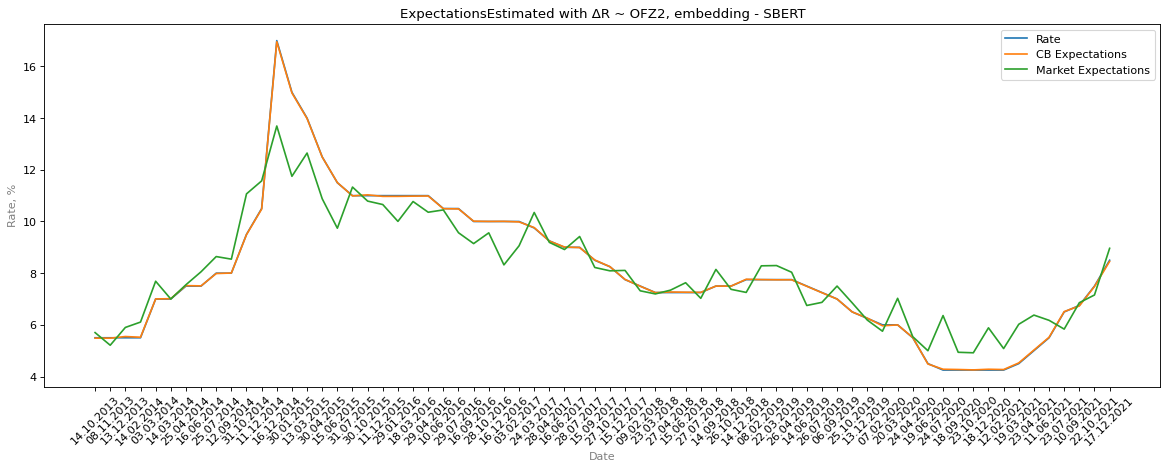

In [ ]:
draw_proxy_expectations(cbr_en.predict(X_previews), news_en.predict(X_news), 'ΔR ~ OFZ2, embedding - SBERT', 9)

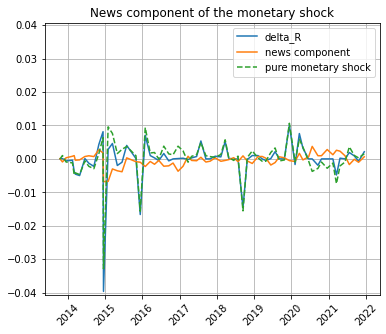

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz2'
news_component_df = pd.DataFrame(data={'date':previews['date'][::-1].reset_index(drop=True),
                   'key_rate': previews['rate'][::-1].reset_index(drop=True).tolist(),
                   f'pure_monetary_shock_{name}': (delta-result.predict(X))[::-1].reset_index(drop=True).tolist(), 
                   f'capured_monetary_shock_{name}': delta[::-1].reset_index(drop=True).tolist(), 
                   f'news_component_{name}': result.predict(X)[::-1].tolist()
                   })

In [ ]:
news_component_df

date  key_rate  pure_monetary_shock_ofz2  \
0  2013-10-14 11:05:00      5.50                 -0.000058   
1  2013-11-08 10:27:00      5.50                  0.001007   
2  2013-12-13 13:27:00      5.50                 -0.000929   
3  2014-02-14 13:33:00      5.50                 -0.001194   
4  2014-03-03 10:26:00      7.00                 -0.004737   
..                 ...       ...                       ...   
63 2021-06-11 13:30:00      5.50                 -0.000932   
64 2021-07-23 13:30:00      6.50                  0.003605   
65 2021-09-10 13:30:00      6.75                  0.001025   
66 2021-10-22 13:30:00      7.50                  0.000297   
67 2021-12-17 13:30:00      8.50                  0.001504   

    capured_monetary_shock_ofz2  news_component_ofz2  
0                      0.000000             0.000058  
1                      0.000100            -0.000907  
2                     -0.000602             0.000327  
3                     -0.000404             0.000791  
4                     -0.003752             0.000985  
..                          ...                  ...  
63                     0.000000             0.000932  
64                     0.001902            -0.001703  
65                     0.000903            -0.000122  
66                    -0.000715            -0.001012  
67                     0.002137             0.000633  

[68 rows x 5 columns]

#### 4-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most ancient to the most recent
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz4']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
delta = deltas_for_futures['delta_ofz4']
# best_params = dict(trial.params.items()) # optuna
best_params = {'alpha_cbr': 0.0053518137951672415,
              'alpha_news': 0.03188171742022633,
              'l1_ratio_cbr': 0.018600204768885433,
              'l1_ratio_news': 0.07774262761000884}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_ofz4   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     14.00
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           0.000385
Time:                        15:43:35   Log-Likelihood:                 189.03
No. Observations:                  68   AIC:                            -374.1
Df Residuals:                      66   BIC:                            -369.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.966      0.3

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.9986
mean_squared_log_error:  0.0002
r2:  0.9986
MAE:  0.0775
MSE:  0.0094
RMSE:  0.0971


Public expectations stats
explained_variance:  0.8324
mean_squared_log_error:  0.013
r2:  0.8324
MAE:  0.7508
MSE:  1.1402
RMSE:  1.0678


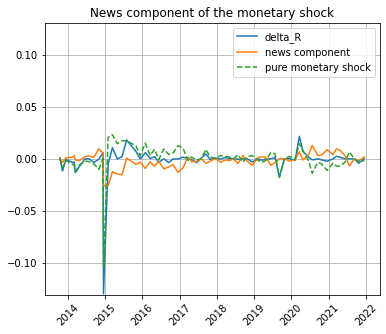

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz4'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

#### 6-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most recent to the most ancient 
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz6']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
delta = deltas_for_futures['delta_ofz6']
best_params = {'alpha_cbr': 0.001041513363924362,
              'alpha_news': 0.02940666316589763,
              'l1_ratio_cbr': 0.08198112817880748,
              'l1_ratio_news': 0.01826997660794514}



news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_ofz6   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     14.39
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           0.000325
Time:                        15:43:42   Log-Likelihood:                 178.48
No. Observations:                  68   AIC:                            -353.0
Df Residuals:                      66   BIC:                            -348.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -1.007      0.3

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.9999
mean_squared_log_error:  0.0
r2:  0.9999
MAE:  0.0203
MSE:  0.0007
RMSE:  0.0255


Public expectations stats
explained_variance:  0.8635
mean_squared_log_error:  0.0108
r2:  0.8635
MAE:  0.6742
MSE:  0.9285
RMSE:  0.9636


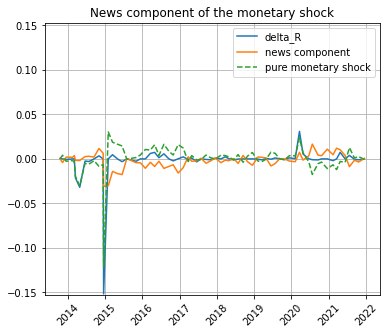

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz6'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

#### 10-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most recent to the most ancient 
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz10']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
delta = deltas_for_futures['delta_ofz10']
best_params = {'alpha_cbr': 3.896627165096069,
                'alpha_news': 6.219784614021191,
                'l1_ratio_cbr': 0.05630869794989198,
                'l1_ratio_news': 0.5842512256155995}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            delta_ofz10   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     6.576
Date:                Thu, 16 Jun 2022   Prob (F-statistic):             0.0126
Time:                        15:43:47   Log-Likelihood:                 208.57
No. Observations:                  68   AIC:                            -413.1
Df Residuals:                      66   BIC:                            -408.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.152      0.2

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.064
mean_squared_log_error:  0.0748
r2:  0.064
MAE:  1.9479
MSE:  6.3656
RMSE:  2.523


Public expectations stats
explained_variance:  0.0
mean_squared_log_error:  0.0799
r2:  0.0
MAE:  2.0281
MSE:  6.801
RMSE:  2.6079


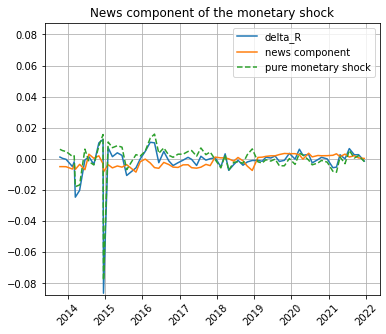

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz10'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

#### 15-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] 
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz15']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
delta = deltas_for_futures['delta_ofz15']
best_params = {'alpha_cbr': 0.5360293994292977,
              'alpha_news': 0.00024472111920897206,
              'l1_ratio_cbr': 0.7392943012836974,
              'l1_ratio_news': 0.06171980833634403}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            delta_ofz15   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     4.551
Date:                Thu, 16 Jun 2022   Prob (F-statistic):             0.0366
Time:                        15:43:55   Log-Likelihood:                 196.41
No. Observations:                  68   AIC:                            -388.8
Df Residuals:                      66   BIC:                            -384.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.465      0.1

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.0483
mean_squared_log_error:  0.0761
r2:  0.0483
MAE:  1.9755
MSE:  6.4725
RMSE:  2.5441


Public expectations stats
explained_variance:  0.9999
mean_squared_log_error:  0.0
r2:  0.9999
MAE:  0.0228
MSE:  0.0009
RMSE:  0.0305


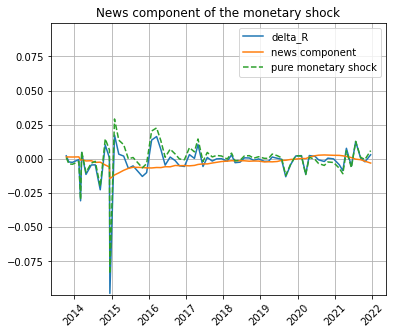

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz15'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

### Currency Futures

First type of instruments was calculated according to the methodology used in Gertler and Karadi (2015), Tishin (2019), Bannikova and Pestova (2021):

$$s_t=\frac{p_{t,\tau+20}-p_{t,\tau-10}}{p_{t,\tau-10}}$$

Here: $s_t$ - is an instrument for a monetary shock; $p_{t,\tau+20}$ - the price of the chosen instrument in the end of the 30-minute window, 20 minutes after the release; $p_{t,\tau-10}$ - the price of the chosen instrument in the beginning of the 30-minute window, 10 minutes before the release.

Though, at it is easier to interprete: positive $s_t$ would mean strengthening of RUB, negative - its fall.

##### USD/RUB

In [ ]:
# delta_usd_rub_futures = get_delta('usd_rub_futures').sort_values(by='date')
# delta_usd_rub_futures['delta_rub_usd'] = [(1/delta_usd_rub_futures['twenty_mins_after'][i] - 1/delta_usd_rub_futures['ten_mins_before'][i]) / (1/delta_usd_rub_futures['ten_mins_before'][i]) for i in range(len(delta_usd_rub_futures))]
# delta_usd_rub_futures['delta_usd_rub'] = [(delta_usd_rub_futures['twenty_mins_after'][i] - delta_usd_rub_futures['ten_mins_before'][i]) / (delta_usd_rub_futures['ten_mins_before'][i]) for i in range(len(delta_usd_rub_futures))]
# delta_usd_rub_futures.to_csv('delta_usd_rub_futures.csv')

delta_usd_rub_futures = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/delta_usd_rub_futures.csv').drop('Unnamed: 0', axis=1)
delta_usd_rub_futures

date  release_time  ten_mins_before  ten_mins_after  \
0   2013-10-14 11:05:00       32598.0          32604.0         32603.0   
1   2013-11-08 10:27:00       32683.0          32674.0         32683.0   
2   2013-12-13 13:27:00       33346.0          33356.0         33350.0   
3   2014-02-14 13:33:00       35346.0          35308.0         35340.0   
4   2014-03-03 10:26:00       36489.0          36473.0         36483.0   
..                  ...           ...              ...             ...   
63  2021-06-11 13:30:00       72659.0          72660.0         72614.0   
64  2021-07-23 13:30:00       74203.0          74263.0         74253.0   
65  2021-09-10 13:30:00       72804.0          72798.0         72886.0   
66  2021-10-22 13:30:00       71166.0          71237.0         70899.0   
67  2021-12-17 13:30:00       75051.0          75139.0         75251.0   

    fifteen_mins_after  twenty_mins_after  delta_rub_usd  delta_usd_rub  
0              32603.0            32601.0       0.000092      -0.000092  
1              32692.0            32683.0      -0.000275       0.000275  
2              33352.0            33349.0       0.000210      -0.000210  
3              35199.0            35234.0       0.002100      -0.002096  
4              36489.0            36529.0      -0.001533       0.001535  
..                 ...                ...            ...            ...  
63             72654.0            72648.0       0.000165      -0.000165  
64             74228.0            74166.0       0.001308      -0.001306  
65             72866.0            72855.0      -0.000782       0.000783  
66             70896.0            70835.0       0.005675      -0.005643  
67             75325.0            75216.0      -0.001024       0.001025  

[68 rows x 8 columns]

In [ ]:
# Run optuna optimisation
delta = delta_usd_rub_futures['delta_rub_usd'][::-1].reset_index(drop=True)

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
delta = delta_usd_rub_futures['delta_rub_usd'][::-1].reset_index(drop=True)
# best_params = dict(trial.params.items()) # optuna

best_params = {'alpha_cbr': 0.004369357546807364,
                'alpha_news': 0.10028879452893769,
                'l1_ratio_cbr': 0.5099513903799241,
                'l1_ratio_news': 0.018171822007950218}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          delta_rub_usd   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.4134
Date:                Thu, 16 Jun 2022   Prob (F-statistic):              0.522
Time:                        15:45:02   Log-Likelihood:                 285.12
No. Observations:                  68   AIC:                            -566.2
Df Residuals:                      66   BIC:                            -561.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.133      0.2

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.2043
mean_squared_log_error:  0.0628
r2:  0.2043
MAE:  1.7957
MSE:  5.4116
RMSE:  2.3263


Public expectations stats
explained_variance:  0.0
mean_squared_log_error:  0.0799
r2:  0.0
MAE:  2.0281
MSE:  6.801
RMSE:  2.6079


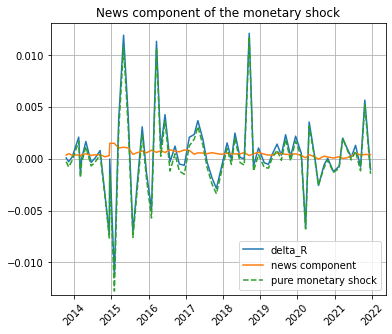

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'futures_rub_usd'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

##### EUR/RUB

In [ ]:
delta_eur_rub_futures = get_delta('eur_rub_futures').sort_values(by='date')

In [ ]:
delta_eur_rub_futures['delta_rub_eur'] = [(1/delta_eur_rub_futures['twenty_mins_after'][i] - 1/delta_eur_rub_futures['ten_mins_before'][i]) / (1/delta_eur_rub_futures['ten_mins_before'][i]) for i in range(len(delta_eur_rub_futures))] 
delta_eur_rub_futures['delta_eur_rub'] = [(delta_eur_rub_futures['twenty_mins_after'][i] - delta_eur_rub_futures['ten_mins_before'][i]) / (delta_eur_rub_futures['ten_mins_before'][i]) for i in range(len(delta_eur_rub_futures))] 

In [ ]:
# Run optuna optimisation
delta = delta_eur_rub_futures['delta_rub_eur'][::-1].reset_index(drop=True)

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
delta = delta_eur_rub_futures['delta_rub_eur'][::-1].reset_index(drop=True)
# best_params = dict(trial.params.items()) # optuna

best_params = {'alpha_cbr': 4.052734898528084,
              'alpha_news': 3.1264324351405404,
              'l1_ratio_cbr': 0.0872908907989,
              'l1_ratio_news': 0.10991084794265468}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          delta_rub_eur   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     3.345
Date:                Wed, 15 Jun 2022   Prob (F-statistic):             0.0719
Time:                        11:33:34   Log-Likelihood:                 245.42
No. Observations:                  68   AIC:                            -486.8
Df Residuals:                      66   BIC:                            -482.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.353      0.1

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.0099
mean_squared_log_error:  0.0791
r2:  0.0099
MAE:  2.0173
MSE:  6.7336
RMSE:  2.5949


Public expectations stats
explained_variance:  0.0
mean_squared_log_error:  0.0799
r2:  0.0
MAE:  2.0281
MSE:  6.801
RMSE:  2.6079


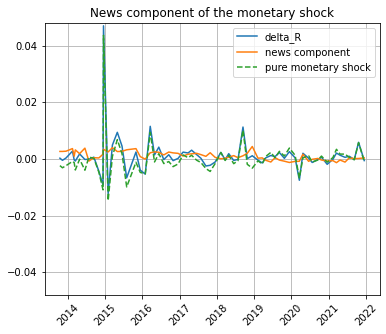

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'futures_rub_eur'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

### First Component of PCA Decomposition

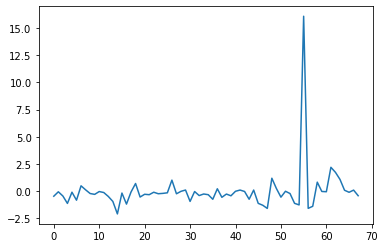

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_pca = deltas_for_futures[['delta_ofz2', 'delta_ofz4', 'delta_ofz6', 'delta_ofz10', 'delta_ofz15']]
data_pca['rub_usd'] = delta_usd_rub_futures['delta_rub_usd'].iloc[::-1].reset_index(drop=True)

sc = StandardScaler()
delta = sc.fit_transform(data_pca)

pca = PCA(n_components=1)
delta = pca.fit_transform(delta)
plt.plot(delta)

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))
study = optuna.create_study(direction = "maximize")

In [ ]:
best_params = {'l1_ratio_news': 0.42194890673975494,
                'l1_ratio_cbr': 0.8906420228700257,
                'alpha_news': 0.02160299953551259,
                'alpha_cbr': 0.0007040114472908001}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     9.850
Date:                Wed, 15 Jun 2022   Prob (F-statistic):            0.00254
Time:                        11:33:35   Log-Likelihood:                -141.95
No. Observations:                  68   AIC:                             287.9
Df Residuals:                      66   BIC:                             292.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.163e-17      0.240   1.73e-16      1.0

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.9998
mean_squared_log_error:  0.0
r2:  0.9998
MAE:  0.0303
MSE:  0.0015
RMSE:  0.0391


Public expectations stats
explained_variance:  0.7966
mean_squared_log_error:  0.0155
r2:  0.7966
MAE:  0.8422
MSE:  1.3834
RMSE:  1.1762


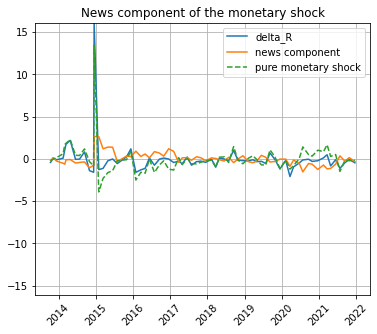

In [ ]:
draw_news_component(delta.reshape(-1,), result.predict(X))

In [ ]:
name = 'one_component'
news_component_df[f'pure_monetary_shock_{name}'] = (delta.reshape(-1,)-result.predict(X))[::-1].tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta.reshape(-1,)[::-1].tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

### UIP-based instrument

#### USD/RUB

In [ ]:
usdrub_rate = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/deltas_for_usd_rub.csv').drop('Unnamed: 0', axis=1)
eurrub_rate = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/deltas_for_eur_rub.csv').drop('Unnamed: 0', axis=1)
delta_usd_rub_futures = delta_usd_rub_futures.iloc[::-1].iloc[:len(eurrub_rate)].reset_index(drop=True)

In [ ]:
delta_usd_rub_futures

date  release_time  ten_mins_before  ten_mins_after  \
0   2021-12-17 13:30:00       75051.0          75139.0         75251.0   
1   2021-10-22 13:30:00       71166.0          71237.0         70899.0   
2   2021-09-10 13:30:00       72804.0          72798.0         72886.0   
3   2021-07-23 13:30:00       74203.0          74263.0         74253.0   
4   2021-06-11 13:30:00       72659.0          72660.0         72614.0   
..                  ...           ...              ...             ...   
61  2014-04-25 13:30:00       36411.0          36421.0         36356.0   
62  2014-03-14 13:30:00       37544.0          37555.0         37554.0   
63  2014-03-03 10:26:00       36489.0          36473.0         36483.0   
64  2014-02-14 13:33:00       35346.0          35308.0         35340.0   
65  2013-12-13 13:27:00       33346.0          33356.0         33350.0   

    fifteen_mins_after  twenty_mins_after  delta_rub_usd  delta_usd_rub  
0              75325.0            75216.0      -0.001024       0.001025  
1              70896.0            70835.0       0.005675      -0.005643  
2              72866.0            72855.0      -0.000782       0.000783  
3              74228.0            74166.0       0.001308      -0.001306  
4              72654.0            72648.0       0.000165      -0.000165  
..                 ...                ...            ...            ...  
61             36339.0            36360.0       0.001678      -0.001675  
62             37560.0            37555.0       0.000000       0.000000  
63             36489.0            36529.0      -0.001533       0.001535  
64             35199.0            35234.0       0.002100      -0.002096  
65             33352.0            33349.0       0.000210      -0.000210  

[66 rows x 8 columns]

In [ ]:
df = pd.DataFrame(columns=['date','UIP_based_delta'])
for i in range(len(usdrub_rate)):
    df = df.append({'date': delta_usd_rub_futures['date'][i],
                   'UIP_based_delta': ((delta_usd_rub_futures['twenty_mins_after'][i]/1000)/usdrub_rate['twenty_mins_after'][i] - (delta_usd_rub_futures['ten_mins_before'][i]/1000)/usdrub_rate['ten_mins_before'][i]) * 
                    365/((16 - datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day) if (datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day < 16) else (27 - datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day + 16))
                    # '10_mins_before': delta_usd_rub_futures['ten_mins_before'][i]/1000)/usdrub_rate['ten_mins_before'][i] * 365/((16 - datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day) if (datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day < 16) else (27 - datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day + 16)),
                    # 'twenty_mins_after': delta_usd_rub_futures['twenty_mins_after'][i]/1000)/usdrub_rate['twenty_mins_after'][i] * 365/((16 - datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day) if (datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day < 16) else (27 - datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day + 16))
                    # suppose for simlicity that all contracts excercise on 16th of each month
                    },
                   ignore_index=True)
df

date  UIP_based_delta
0   2021-12-17 13:30:00         0.007867
1   2021-10-22 13:30:00         0.005569
2   2021-09-10 13:30:00        -0.000476
3   2021-07-23 13:30:00        -0.005291
4   2021-06-11 13:30:00         0.003282
..                  ...              ...
61  2014-04-25 13:30:00         0.001617
62  2014-03-14 13:30:00         0.012777
63  2014-03-03 10:26:00         0.017662
64  2014-02-14 13:33:00         0.007412
65  2013-12-13 13:27:00        -0.008996

[66 rows x 2 columns]

In [ ]:
# from scipy.stats import t
# x=df['UIP_based_delta']
# m = x.mean() 
# s = x.std() 
# dof = len(x)-1 
# confidence = 0.99
# t_crit = np.abs(t.ppf((1-confidence)/2,dof))

# (m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)))

In [ ]:
y = previews['rate'][:66] # note that all variables are transforemed so that the dates are from the most ancient to the most recent
X_previews = previews_embeddings[:66]
X_news = news_embeddings[:66]
delta = df['UIP_based_delta']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
y = previews['rate'][:66] # note that all variables are transforemed so that the dates are from the most ancient to the most recent
X_previews = previews_embeddings[:66]
X_news = news_embeddings[:66]
delta = df['UIP_based_delta']

best_params = {'alpha_cbr': 0.0028077103491548363,
                'alpha_news': 0.026438185994793584,
                'l1_ratio_cbr': 0.025516941830357485,
                'l1_ratio_news': 0.3197001119526305}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        UIP_based_delta   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     20.40
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           2.76e-05
Time:                        11:33:40   Log-Likelihood:                 71.080
No. Observations:                  66   AIC:                            -138.2
Df Residuals:                      64   BIC:                            -133.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0193      0.010     -1.872      0.0

CBR expectations stats
explained_variance:  0.9996
mean_squared_log_error:  0.0
r2:  0.9996
MAE:  0.0422
MSE:  0.0027
RMSE:  0.0523


Public expectations stats
explained_variance:  0.7839
mean_squared_log_error:  0.0165
r2:  0.7839
MAE:  0.8682
MSE:  1.4688
RMSE:  1.2119


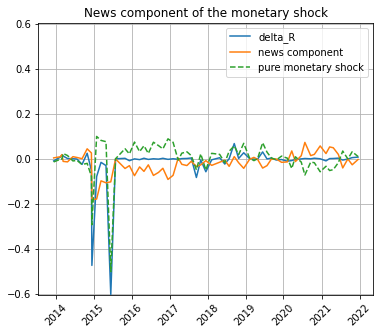

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

draw_news_component(delta, result.predict(X))

In [ ]:
news_component_df = pd.read_csv('news_component_sbert.csv').drop('Unnamed: 0', axis=1)
name = 'uip_based_usd'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist() + [0]*2
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()+ [0]*2
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()+ [0]*2

#### EUR/RUB

In [ ]:
delta_eur_rub_futures = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/delta_eur_rub_futures.csv').drop('Unnamed: 0', axis=1)
delta_eur_rub_futures = delta_eur_rub_futures.iloc[::-1].iloc[:len(eurrub_rate)].reset_index(drop=True)

In [ ]:
df = pd.DataFrame(columns=['date','UIP_based_delta'])
for i in range(len(eurrub_rate)):
    df = df.append({'date': delta_eur_rub_futures['date'][i],
                   'UIP_based_delta': ((delta_eur_rub_futures['twenty_mins_after'][i]/1000)/eurrub_rate['twenty_mins_after'][i] - (delta_eur_rub_futures['ten_mins_before'][i]/1000)/eurrub_rate['ten_mins_before'][i]) * 
                    365/((16 - datetime.strptime(delta_eur_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day) if (datetime.strptime(delta_eur_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day < 16) else (27 - datetime.strptime(delta_usd_rub_futures['date'][i], '%Y-%m-%d %H:%M:%S').day + 16))
                    # suppose for simlicity that all contracts excercise on 16th of each month
                    },
                   ignore_index=True)
df

date  UIP_based_delta
0   2021-12-17 13:30:00         0.002725
1   2021-10-22 13:30:00         0.005940
2   2021-09-10 13:30:00        -0.002495
3   2021-07-23 13:30:00        -0.001958
4   2021-06-11 13:30:00         0.001530
..                  ...              ...
61  2014-04-25 13:30:00         0.006475
62  2014-03-14 13:30:00        -0.020070
63  2014-03-03 10:26:00        -0.028184
64  2014-02-14 13:33:00        -0.058373
65  2013-12-13 13:27:00        -0.000725

[66 rows x 2 columns]

In [ ]:
# from scipy.stats import t
# x=df['UIP_based_delta']
# m = x.mean() 
# s = x.std() 
# dof = len(x)-1 
# confidence = 0.99
# t_crit = np.abs(t.ppf((1-confidence)/2,dof))

# (m-s*t_crit/np.sqrt(len(x)), m+s*t_crit/np.sqrt(len(x)))

In [ ]:
y = previews['rate'][:66] # note that all variables are transforemed so that the dates are from the most ancient to the most recent
X_previews = previews_embeddings[:66]
X_news = news_embeddings[:66]
delta = df['UIP_based_delta']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
y = previews['rate'][:66] # note that all variables are transforemed so that the dates are from the most ancient to the most recent
X_previews = previews_embeddings[:66]
X_news = news_embeddings[:66]
delta = df['UIP_based_delta']

best_params = {'alpha_cbr': 0.007223663523412646,
                'alpha_news': 0.028699367950615562,
                'l1_ratio_cbr': 0.09270115236833648,
                'l1_ratio_news': 0.3432692428275491}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        UIP_based_delta   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     19.83
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           3.47e-05
Time:                        11:33:55   Log-Likelihood:                 44.988
No. Observations:                  66   AIC:                            -85.98
Df Residuals:                      64   BIC:                            -81.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0233      0.015     -1.524      0.1

CBR expectations stats
explained_variance:  0.9966
mean_squared_log_error:  0.0004
r2:  0.9966
MAE:  0.1208
MSE:  0.0233
RMSE:  0.1527


Public expectations stats
explained_variance:  0.7613
mean_squared_log_error:  0.0182
r2:  0.7613
MAE:  0.916
MSE:  1.6226
RMSE:  1.2738


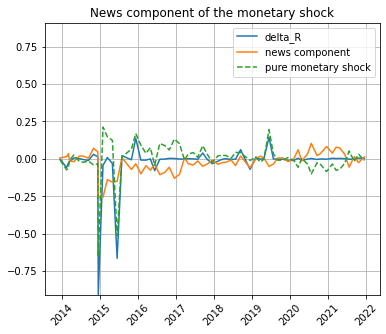

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

draw_news_component(delta, result.predict(X))

In [ ]:
name = 'uip_based_eur'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist() + [0]*2
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()+ [0]*2
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()+ [0]*2

In [ ]:
news_component_df.to_csv('news_component_sbert.csv')

## DeepPavlov embeddings (unstable results - did not use them in further analysis)

In [ ]:
# hyperparameter optimization using optuna library
def objective(trial):
    l1_ratio_news = trial.suggest_float('l1_ratio_news', 0, 1)
    l1_ratio_cbr = trial.suggest_float('l1_ratio_cbr', 0, 1)
    alpha_news = trial.suggest_float('alpha_news', 0, 10)
    alpha_cbr = trial.suggest_float('alpha_cbr', 0, 10)
    elnet_news = ElasticNet(l1_ratio=l1_ratio_news, alpha=alpha_news).fit(X_news, y)
    elnet_releases = ElasticNet(l1_ratio=l1_ratio_cbr, alpha=alpha_cbr).fit(X_previews, y)

    delta_E = (elnet_news.predict(X_news) - elnet_releases.predict(X_previews)).reshape(-1,1)
    X = sm.add_constant(delta_E)

    results = sm.OLS(delta, X).fit()
    # results = sm.OLS(delta, delta_E).fit()
    return  results.rsquared

In [ ]:
#❗Getting the pretrained embeddings
previews = pd.read_excel('./cbr_previews.xlsx').drop('Unnamed: 0', axis=1)

# the embeddings were already made
news_embeddings = torch.load('./news_rbc_13062022_deeppavlov.pt')
previews_embeddings = torch.load('./cb_1306022_deeppavlov.pt')

### OFZ futures

The problem of this instrument is that the data is available only with a daily frequency (or more - up to 5 days because of the gaps in data). Therefore, there is a lot of space for endogeneity.

The price in the dataset is presented for the end of the day. We suppose that if the monetary shock is present, then there was at least one transaction at the day of press-release. Then we will construct an instrument as:

$$s_t=\frac{p_{t,\tau}-p_{t,\tau-1}}{p_{t,\tau-1}}$$

Here: $s_t$ - is an instrument for a monetary shock; $p_{t,\tau}$ - the price of the chosen instrument by the end of the press release day $t$; $p_{t,\tau-1}$ - the price of the chosen instrument after teh last transaction before the press release day $t$.

In [ ]:
#@markdown Original code for delta construction. To recreate further computations it will be sufficient to import `.csv` file from github (implemented in the last line).

# deltas_for_futures = pd.DataFrame(columns=['date', 
#                                            'ofz2', 'ofz2_previous', 'delta_ofz2',
#                                            'ofz4', 'ofz4_previous', 'delta_ofz4',
#                                            'ofz6', 'ofz6_previous', 'delta_ofz6',
#                                            'ofz10', 'ofz10_previous', 'delta_ofz10',
#                                            'ofz15', 'ofz15_previous', 'delta_ofz15'])

# urls = ['https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OFZ2_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OFZ4_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OFZ6_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OF10_130901_220101.csv',
#         'https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/instrument_prices/OFZ_futures/SPFB.OF15_130901_220101.csv']

# futures_2 = pd.read_csv(urls[0], ';')
# futures_4 = pd.read_csv(urls[1], ';')
# futures_6 = pd.read_csv(urls[2], ';')
# futures_10 = pd.read_csv(urls[3], ';')
# futures_15 = pd.read_csv(urls[4], ';')


# def change_futures_df(df):
#     df['date'] = [0]*len(df)
#     for i in range(len(df)):
#         df['date'][i] = datetime(int('20'+df['<DATE>'][i][-2:]),
#                                 int(df['<DATE>'][i][3:5]),
#                                 int(df['<DATE>'][i][:2]))
#     df = df[['date', '<OPEN>']].rename(columns={'<OPEN>':'price'})
#     return df

# futures_2 = change_futures_df(futures_2)
# futures_4 = change_futures_df(futures_4)
# futures_6 = change_futures_df(futures_6)
# futures_10 = change_futures_df(futures_10)
# futures_15 = change_futures_df(futures_15)


# for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#     try:
#         deltas_for_futures = deltas_for_futures.append({'date': preview_date,
#                               'ofz2': futures_2['price'][futures_2['date'] == preview_date].iloc[0]}, ignore_index=True)
#     except:
#         deltas_for_futures = deltas_for_futures.append({'date': preview_date,
#                               'ofz2': 0}, ignore_index=True)
        


# previous = []
# for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#     try:
#         previous.append(futures_2['price'][futures_2['date'] == (preview_date-timedelta(days=1))].iloc[0])
#     except:
#         lenght = len(previous)
#         i=2
#         while len(previous) == lenght:
#             try:
#                 previous.append(futures_2['price'][futures_2['date'] == (preview_date-timedelta(days=i))].iloc[0])
#             except:
#                 i += 1
#                 pass

# deltas_for_futures['ofz2_previous'] = previous
# deltas_for_futures['delta_ofz2'] = [(deltas_for_futures['ofz2'][i] - deltas_for_futures['ofz2_previous'][i]) / deltas_for_futures['ofz2_previous'][i] if deltas_for_futures['ofz2'][i] !=0 else 0 for i in range(len(deltas_for_futures))]


# for futures in [4,6,10,15]:
#     dataset = futures_4 if futures == 4 else futures_6 if futures == 6 else futures_10 if futures == 10 else futures_15

#     current = []
#     for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#         try:
#             current.append(dataset['price'][dataset['date'] == preview_date].iloc[0])
#         except:
#             current.append(0)
#     deltas_for_futures[f'ofz{futures}'] = current
#     previous = []
#     for preview_date in [datetime(date.year, date.month, date.day) for date in previews['date']]:
#         try:
#             previous.append(dataset['price'][dataset['date'] == (preview_date-timedelta(days=1))].iloc[0])
#         except:
#             lenght = len(previous)
#             i=2
#             while len(previous) == lenght:
#                 try:
#                     previous.append(dataset['price'][dataset['date'] == (preview_date-timedelta(days=i))].iloc[0])
#                 except:
#                     i += 1
#                     pass

#     deltas_for_futures[f'ofz{futures}_previous'] = previous
#     deltas_for_futures[f'delta_ofz{futures}'] = [(deltas_for_futures[f'ofz{futures}'][i] - deltas_for_futures[f'ofz{futures}_previous'][i]) / deltas_for_futures[f'ofz{futures}_previous'][i] if deltas_for_futures[f'ofz{futures}'][i] !=0 else 0 for i in range(len(deltas_for_futures))]

deltas_for_futures = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/computed_monetary_shocks/deltas_for_futures.csv').drop(columns='Unnamed: 0')
deltas_for_futures

date     ofz2  ofz2_previous  delta_ofz2     ofz4  ofz4_previous  \
0   2021-12-17   9849.0         9828.0    0.002137      0.0        10098.0   
1   2021-10-22   9790.0         9797.0   -0.000715   9620.0         9660.0   
2   2021-09-10   9978.0         9969.0    0.000903      0.0         9880.0   
3   2021-07-23  10009.0         9990.0    0.001902      0.0         9975.0   
4   2021-06-11      0.0        10009.0    0.000000      0.0         9923.0   
..         ...      ...            ...         ...      ...            ...   
63  2014-03-03   9825.0         9862.0   -0.003752   9900.0         9929.0   
64  2014-02-14   9909.0         9913.0   -0.000404  10056.0        10091.0   
65  2013-12-13   9959.0         9965.0   -0.000602  10189.0        10194.0   
66  2013-11-08  10029.0        10028.0    0.000100   9904.0        10020.0   
67  2013-10-14      0.0        10024.0    0.000000   9904.0         9894.0   

    delta_ofz4     ofz6  ofz6_previous  delta_ofz6    ofz10  ofz10_previous  \
0     0.000000      0.0        10804.0    0.000000   9054.0          9067.0   
1    -0.004141   9701.0         9711.0   -0.001030   9630.0          9604.0   
2     0.000000  10034.0        10038.0   -0.000398   9971.0          9945.0   
3     0.000000   9817.0         9779.0    0.003886  10480.0         10411.0   
4     0.000000      0.0         9719.0    0.000000      0.0         10362.0   
..         ...      ...            ...         ...      ...             ...   
63   -0.002921      0.0        10319.0    0.000000  10250.0         10269.0   
64   -0.003468      0.0        10456.0    0.000000  10431.0         10483.0   
65   -0.000490  10568.0        10575.0   -0.000662  10600.0         10603.0   
66   -0.011577      0.0        10375.0    0.000000  11048.0         11044.0   
67    0.001011  10369.0        10365.0    0.000386  11022.0         11009.0   

    delta_ofz10    ofz15  ofz15_previous  delta_ofz15  
0     -0.001434   9358.0          9330.0     0.003001  
1      0.002707  10777.0         10800.0    -0.002130  
2      0.002614  11184.0         11178.0     0.000537  
3      0.006628  10329.0         10200.0     0.012647  
4      0.000000  10034.0         10089.0    -0.005451  
..          ...      ...             ...          ...  
63    -0.001850  10207.0         10530.0    -0.030674  
64    -0.004960  10710.0         10715.0    -0.000467  
65    -0.000283  10877.0         10905.0    -0.002568  
66     0.000362  11220.0         11245.0    -0.002223  
67     0.001181  11170.0         11145.0     0.002243  

[68 rows x 16 columns]

#### 2-year-bonds replicating futures 


In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most ancient to the most recent
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz2']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-06-13 17:23:15,130] A new study created in memory with name: no-name-d5527bc9-d77c-45e0-9628-f9cff602b35a
[I 2022-06-13 17:23:15,159] Trial 0 finished with value: 0.03861322851612303 and parameters: {'l1_ratio_news': 0.3309557946870171, 'l1_ratio_cbr': 0.013205944168969364, 'alpha_news': 0.6342921004461399, 'alpha_cbr': 1.696423247248372}. Best is trial 0 with value: 0.03861322851612303.
[I 2022-06-13 17:23:15,181] Trial 1 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.8551730580034187, 'l1_ratio_cbr': 0.35966138709692974, 'alpha_news': 2.548955000818375, 'alpha_cbr': 5.228709369540625}. Best is trial 0 with value: 0.03861322851612303.
[I 2022-06-13 17:23:15,200] Trial 2 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.27984054255707336, 'l1_ratio_cbr': 0.508532508079253, 'alpha_news': 0.9290780500084994, 'alpha_cbr': 4.916347479865417}. Best is trial 0 with value: 0.03861322851612303.
[I 2022-06-13 17:23:15,228] Trial 3 finished with value: 0.04502711

Best Score:  0.085152218071333
Best Params: 
  l1_ratio_news: 0.14279200307883713
  l1_ratio_cbr: 0.9430076319745052
  alpha_news: 6.838380593251497
  alpha_cbr: 0.2671604243629783


In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 0.0009108557825152252,
              'alpha_news': 0.014324081810594415,
              'l1_ratio_cbr': 0.001233612200440811,
              'l1_ratio_news': 0.3744865623476463}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_ofz2   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     5.906
Date:                Mon, 13 Jun 2022   Prob (F-statistic):             0.0178
Time:                        17:27:12   Log-Likelihood:                 252.49
No. Observations:                  68   AIC:                            -501.0
Df Residuals:                      66   BIC:                            -496.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.505      0.6

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  1.0
mean_squared_log_error:  0.0
r2:  1.0
MAE:  0.0141
MSE:  0.0003
RMSE:  0.0177


Public expectations stats
explained_variance:  0.7996
mean_squared_log_error:  0.0155
r2:  0.7996
MAE:  0.8308
MSE:  1.3632
RMSE:  1.1676


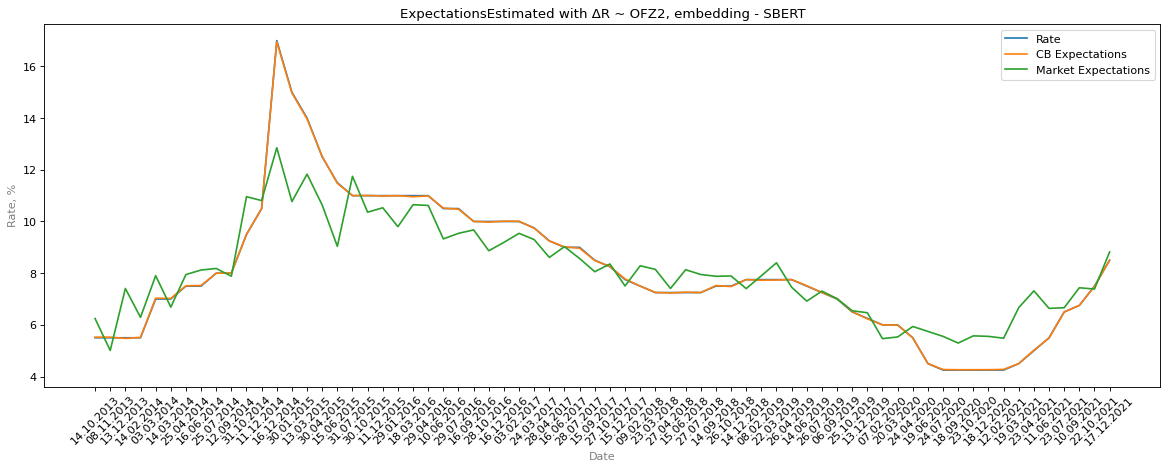

In [ ]:
draw_proxy_expectations(cbr_en.predict(X_previews), news_en.predict(X_news), 'ΔR ~ OFZ2, embedding - SBERT', 9)

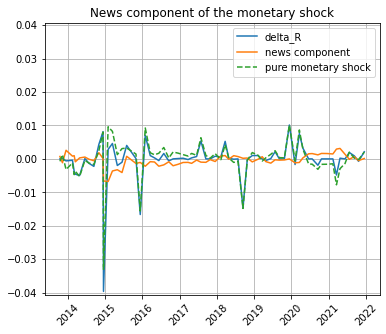

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz2'
news_component_df = pd.DataFrame(data={'date':previews['date'],
                   f'key_rate_{name}': previews['rate'][::-1].reset_index(drop=True).tolist(),
                   f'pure_monetary_shock_{name}': (delta-result.predict(X))[::-1].reset_index(drop=True).tolist(), 
                   f'capured_monetary_shock_{name}': delta[::-1].reset_index(drop=True).tolist(), 
                   f'news_component_{name}': result.predict(X)[::-1].tolist()
                   })

#### 4-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most ancient to the most recent
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz4']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-06-13 17:27:14,377] A new study created in memory with name: no-name-a0ce78dc-fb76-4d6a-acbd-763b9b28f757
[I 2022-06-13 17:27:14,400] Trial 0 finished with value: -2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.32532773488968314, 'l1_ratio_cbr': 0.18188230256266813, 'alpha_news': 7.855842223111599, 'alpha_cbr': 7.288872950234042}. Best is trial 0 with value: -2.220446049250313e-16.
[I 2022-06-13 17:27:14,413] Trial 1 finished with value: 0.10147988377846795 and parameters: {'l1_ratio_news': 0.6026240492677236, 'l1_ratio_cbr': 0.35610988747839245, 'alpha_news': 3.048717653637507, 'alpha_cbr': 1.266298983332016}. Best is trial 1 with value: 0.10147988377846795.
[I 2022-06-13 17:27:14,427] Trial 2 finished with value: -2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.843704036781302, 'l1_ratio_cbr': 0.8993680153505862, 'alpha_news': 2.500891904155531, 'alpha_cbr': 5.281544607300298}. Best is trial 1 with value: 0.10147988377846795.
[I 2022-06-13 17:27:14,441] T

Best Score:  0.12248662092142504
Best Params: 
  l1_ratio_news: 0.5555529235016321
  l1_ratio_cbr: 0.8920364580506799
  alpha_news: 8.34098697197783
  alpha_cbr: 0.5916314544235257


In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params = {'alpha_cbr': 0.0053518137951672415,
              'alpha_news': 0.03188171742022633,
              'l1_ratio_cbr': 0.018600204768885433,
              'l1_ratio_news': 0.07774262761000884}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_ofz4   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     12.82
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           0.000651
Time:                        17:31:13   Log-Likelihood:                 188.53
No. Observations:                  68   AIC:                            -373.1
Df Residuals:                      66   BIC:                            -368.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.002     -0.959      0.3

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.9986
mean_squared_log_error:  0.0001
r2:  0.9986
MAE:  0.076
MSE:  0.0093
RMSE:  0.0963


Public expectations stats
explained_variance:  0.7246
mean_squared_log_error:  0.0211
r2:  0.7246
MAE:  0.9664
MSE:  1.8731
RMSE:  1.3686


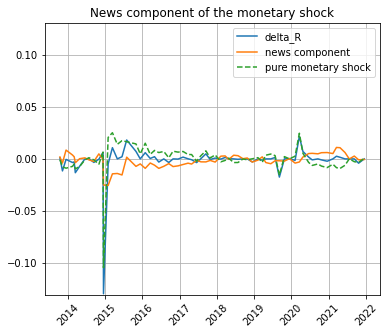

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz4'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

#### 6-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most recent to the most ancient 
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz6']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-06-13 17:31:13,682] A new study created in memory with name: no-name-c59d8cc2-2260-4233-866d-8241ab886af0
[I 2022-06-13 17:31:13,704] Trial 0 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.23926130256146083, 'l1_ratio_cbr': 0.19514789156975743, 'alpha_news': 7.949334421401176, 'alpha_cbr': 3.338342305973343}. Best is trial 0 with value: 0.0.
[I 2022-06-13 17:31:13,728] Trial 1 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.548971099425239, 'l1_ratio_cbr': 0.8798509827353412, 'alpha_news': 6.790875010533934, 'alpha_cbr': 8.54660604187806}. Best is trial 0 with value: 0.0.
[I 2022-06-13 17:31:13,751] Trial 2 finished with value: 0.004236956273227177 and parameters: {'l1_ratio_news': 0.2761802189712219, 'l1_ratio_cbr': 0.6176761326061051, 'alpha_news': 0.44225090128645284, 'alpha_cbr': 4.915021061797788}. Best is trial 2 with value: 0.004236956273227177.
[I 2022-06-13 17:31:13,772] Trial 3 finished with value: 0.07630042968718731 and parameters: {'l1_ra

Best Score:  0.15145039191438903
Best Params: 
  l1_ratio_news: 0.3358729640138598
  l1_ratio_cbr: 0.6463412725939303
  alpha_news: 2.1345702480784277
  alpha_cbr: 6.452940358111256e-06


In [ ]:
dict(trial.params.items())

{'alpha_cbr': 6.452940358111256e-06,
 'alpha_news': 2.1345702480784277,
 'l1_ratio_cbr': 0.6463412725939303,
 'l1_ratio_news': 0.3358729640138598}

In [ ]:
best_params = {'alpha_cbr': 0.001041513363924362,
              'alpha_news': 0.02940666316589763,
              'l1_ratio_cbr': 0.08198112817880748,
              'l1_ratio_news': 0.01826997660794514}



news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             delta_ofz6   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     13.23
Date:                Mon, 13 Jun 2022   Prob (F-statistic):           0.000541
Time:                        17:35:57   Log-Likelihood:                 177.99
No. Observations:                  68   AIC:                            -352.0
Df Residuals:                      66   BIC:                            -347.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.002     -0.999      0.3

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.9999
mean_squared_log_error:  0.0
r2:  0.9999
MAE:  0.0201
MSE:  0.0006
RMSE:  0.0253


Public expectations stats
explained_variance:  0.7638
mean_squared_log_error:  0.018
r2:  0.7638
MAE:  0.8955
MSE:  1.6065
RMSE:  1.2675


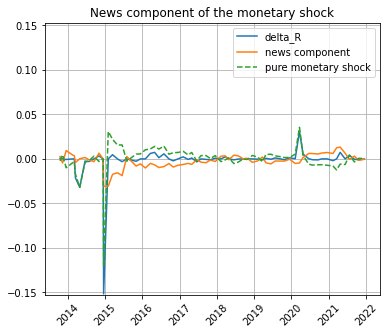

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz6'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

#### 10-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] # note that all variables are transforemed so that the dates are from the most recent to the most ancient 
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz10']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-06-13 17:35:57,514] A new study created in memory with name: no-name-ba4a7b6f-ebcf-4928-b7bf-d0082a51a696
[I 2022-06-13 17:35:57,540] Trial 0 finished with value: 2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.6624893425581901, 'l1_ratio_cbr': 0.7725066908746286, 'alpha_news': 8.679592142511979, 'alpha_cbr': 5.3784452783835235}. Best is trial 0 with value: 2.220446049250313e-16.
[I 2022-06-13 17:35:57,560] Trial 1 finished with value: 2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.32002650129143895, 'l1_ratio_cbr': 0.9286167944282696, 'alpha_news': 2.0149200545687584, 'alpha_cbr': 4.583656190226195}. Best is trial 0 with value: 2.220446049250313e-16.
[I 2022-06-13 17:35:57,592] Trial 2 finished with value: 0.051099527702330505 and parameters: {'l1_ratio_news': 0.08186135026279939, 'l1_ratio_cbr': 0.5232705882273592, 'alpha_news': 8.424378564594505, 'alpha_cbr': 0.18817639676787512}. Best is trial 2 with value: 0.051099527702330505.
[I 2022-06-13 17:35:57,6

Best Score:  0.09886044232280233
Best Params: 
  l1_ratio_news: 0.8243980421413912
  l1_ratio_cbr: 0.6895738462829248
  alpha_news: 5.510959051613428
  alpha_cbr: 0.7662136420749004


In [ ]:
dict(trial.params.items())

{'alpha_cbr': 0.7662136420749004,
 'alpha_news': 5.510959051613428,
 'l1_ratio_cbr': 0.6895738462829248,
 'l1_ratio_news': 0.8243980421413912}

In [ ]:
best_params = {'alpha_cbr': 3.896627165096069,
                'alpha_news': 6.219784614021191,
                'l1_ratio_cbr': 0.05630869794989198,
                'l1_ratio_news': 0.5842512256155995}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            delta_ofz10   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.998
Date:                Mon, 13 Jun 2022   Prob (F-statistic):             0.0880
Time:                        17:39:51   Log-Likelihood:                 206.85
No. Observations:                  68   AIC:                            -409.7
Df Residuals:                      66   BIC:                            -405.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0016      0.001     -1.123      0.2

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.0937
mean_squared_log_error:  0.0724
r2:  0.0937
MAE:  1.9102
MSE:  6.1636
RMSE:  2.4827


Public expectations stats
explained_variance:  0.0
mean_squared_log_error:  0.0799
r2:  0.0
MAE:  2.0281
MSE:  6.801
RMSE:  2.6079


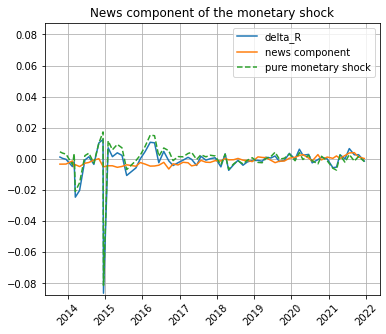

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz10'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

#### 15-year-bonds replicating futures 

In [ ]:
# Run optuna optimisation
y = previews['rate'] 
X_previews = previews_embeddings
X_news = news_embeddings
delta = deltas_for_futures['delta_ofz15']

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2022-06-13 17:39:52,238] A new study created in memory with name: no-name-81446c86-dfbd-4620-a776-57ce602d62b2
[I 2022-06-13 17:39:52,272] Trial 0 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.8157232207334767, 'l1_ratio_cbr': 0.8686177955453874, 'alpha_news': 9.781893791342055, 'alpha_cbr': 3.406154550541932}. Best is trial 0 with value: 0.0.
[I 2022-06-13 17:39:52,289] Trial 1 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.3057980858126049, 'l1_ratio_cbr': 0.8585421486290412, 'alpha_news': 1.5046980524861964, 'alpha_cbr': 9.043943638070983}. Best is trial 0 with value: 0.0.
[I 2022-06-13 17:39:52,307] Trial 2 finished with value: 0.03544150383765676 and parameters: {'l1_ratio_news': 0.6041140646384614, 'l1_ratio_cbr': 0.05327941468039332, 'alpha_news': 3.2220416958319764, 'alpha_cbr': 5.600083479807213}. Best is trial 2 with value: 0.03544150383765676.
[I 2022-06-13 17:39:52,324] Trial 3 finished with value: 0.0421100563087321 and parameters: {'l1_rati

In [ ]:
best_params = {'alpha_cbr': 0.5360293994292977,
              'alpha_news': 0.00024472111920897206,
              'l1_ratio_cbr': 0.7392943012836974,
              'l1_ratio_news': 0.06171980833634403}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            delta_ofz15   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     3.889
Date:                Mon, 13 Jun 2022   Prob (F-statistic):             0.0528
Time:                        17:43:39   Log-Likelihood:                 196.09
No. Observations:                  68   AIC:                            -388.2
Df Residuals:                      66   BIC:                            -383.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0024      0.002     -1.458      0.1

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

In [ ]:
draw_news_component(delta, result.predict(X))

In [ ]:
name = 'ofz15'
news_component_df[f'pure_monetary_shock_{name}'] = (delta-result.predict(X))[::-1].reset_index(drop=True).tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta[::-1].reset_index(drop=True).tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

### Currency Futures

First type of instruments was calculated according to the methodology used in Gertler and Karadi (2015), Tishin (2019), Bannikova and Pestova (2021):

$$s_t=\frac{p_{t,\tau+20}-p_{t,\tau-10}}{p_{t,\tau-10}}$$

Here: $s_t$ - is an instrument for a monetary shock; $p_{t,\tau+20}$ - the price of the chosen instrument in the end of the 30-minute window, 20 minutes after the release; $p_{t,\tau-10}$ - the price of the chosen instrument in the beginning of the 30-minute window, 10 minutes before the release.

Though, at it is easier to interprete: positive $s_t$ would mean strengthening of RUB, negative - its fall.

##### USD/RUB

In [ ]:
delta_usd_rub_futures = get_delta('usd_rub_futures').sort_values(by='date')
delta_usd_rub_futures['delta_rub_usd'] = [(1/delta_usd_rub_futures['twenty_mins_after'][i] - 1/delta_usd_rub_futures['ten_mins_before'][i]) / (1/delta_usd_rub_futures['ten_mins_before'][i]) for i in range(len(delta_usd_rub_futures))]
delta_usd_rub_futures['delta_usd_rub'] = [(delta_usd_rub_futures['twenty_mins_after'][i] - delta_usd_rub_futures['ten_mins_before'][i]) / (delta_usd_rub_futures['ten_mins_before'][i]) for i in range(len(delta_usd_rub_futures))]
delta_usd_rub_futures

In [ ]:
# Run optuna optimisation
delta = delta_usd_rub_futures['delta_rub_usd'][::-1].reset_index(drop=True)

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
# best_params = dict(trial.params.items()) # optuna

best_params = {'alpha_cbr': 0.004369357546807364,
                'alpha_news': 0.10028879452893769,
                'l1_ratio_cbr': 0.5099513903799241,
                'l1_ratio_news': 0.018171822007950218}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.9952
mean_squared_log_error:  0.0004
r2:  0.9952
MAE:  0.1393
MSE:  0.0325
RMSE:  0.1802


Public expectations stats
explained_variance:  0.5329
mean_squared_log_error:  0.0361
r2:  0.5329
MAE:  1.2492
MSE:  3.1768
RMSE:  1.7824


In [ ]:
draw_news_component(delta, result.predict(X))

##### EUR/RUB

In [ ]:
delta_eur_rub_futures = get_delta('eur_rub_futures').sort_values(by='date')

In [ ]:
delta_eur_rub_futures['delta_rub_eur'] = [(1/delta_eur_rub_futures['twenty_mins_after'][i] - 1/delta_eur_rub_futures['ten_mins_before'][i]) / (1/delta_eur_rub_futures['ten_mins_before'][i]) for i in range(len(delta_eur_rub_futures))] 
delta_eur_rub_futures['delta_eur_rub'] = [(delta_eur_rub_futures['twenty_mins_after'][i] - delta_eur_rub_futures['ten_mins_before'][i]) / (delta_eur_rub_futures['ten_mins_before'][i]) for i in range(len(delta_eur_rub_futures))] 

In [ ]:
# Run optuna optimisation
delta = delta_eur_rub_futures['delta_rub_eur'][::-1].reset_index(drop=True)

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
dict(trial.params.items())

In [ ]:
# best_params = dict(trial.params.items()) # optuna

best_params = {'alpha_cbr': 4.052734898528084,
              'alpha_news': 3.1264324351405404,
              'l1_ratio_cbr': 0.0872908907989,
              'l1_ratio_news': 0.10991084794265468}

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

CBR expectations stats
explained_variance:  0.0228
mean_squared_log_error:  0.0781
r2:  0.0228
MAE:  2.0004
MSE:  6.646
RMSE:  2.578


Public expectations stats
explained_variance:  0.0
mean_squared_log_error:  0.0799
r2:  0.0
MAE:  2.0281
MSE:  6.801
RMSE:  2.6079


In [ ]:
draw_news_component(delta, result.predict(X))

### First Component of PCA Decomposition

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_pca = deltas_for_futures[['delta_ofz2', 'delta_ofz4', 'delta_ofz6', 'delta_ofz10', 'delta_ofz15']]
data_pca['rub_usd'] = delta_usd_rub_futures['delta_rub_usd'].iloc[::-1].reset_index(drop=True)

sc = StandardScaler()
delta = sc.fit_transform(data_pca)

pca = PCA(n_components=1)
delta = pca.fit_transform(X_train)
plt.plot(delta)

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 2000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))
study = optuna.create_study(direction = "maximize")

In [ ]:
best_params = {'l1_ratio_news': 0.42194890673975494,
                'l1_ratio_cbr': 0.8906420228700257,
                'alpha_news': 0.02160299953551259,
                'alpha_cbr': 0.0007040114472908001}


news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y)
delta_E = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_E)
result = sm.OLS(delta, X).fit()
print(result.summary())

In [ ]:
# descriptive statistics for CBR expectations
print('CBR expectations stats')
regression_results(y, cbr_en.predict(X_previews))
# descriptive statistics for public expectations
print('\n\nPublic expectations stats')
regression_results(y, news_en.predict(X_news))

In [ ]:
draw_news_component(delta.reshape(-1,), result.predict(X))

In [ ]:
name = 'one_component'
news_component_df[f'pure_monetary_shock_{name}'] = (delta.reshape(-1,)-result.predict(X))[::-1].tolist()
news_component_df[f'capured_monetary_shock_{name}'] = delta.reshape(-1,)[::-1].tolist()
news_component_df[f'news_component_{name}'] = result.predict(X)[::-1].tolist()

# Exploring transition mechanism

We want to check the impact of the news component on several macroeconomic variables. The available data has quarterly frequency, therefore it was decided that we will estimate the impact on the GDP in the next quarter. But if the press-releas occured during the first month of the quarter, the effect will be estimated for the current month as the news effect (relatively small as it is) would not have much effect newrly two quarters in the future.

In [ ]:
variables = pd.read_csv('https://raw.githubusercontent.com/tssorokina/information_component_of_monetary_shocks/main/svar_dataset.csv')

In [ ]:
list(variables)

['Unnamed: 0',
 'year',
 'quarter',
 'month',
 'cpi_to_2010',
 'monthly_inflation',
 'ip_to_2014',
 'ip',
 'credit_spread',
 'vix',
 'neer',
 'mortgage_spread',
 'pure_monetary_shock_ofz2',
 'capured_monetary_shock_ofz2',
 'news_component_ofz2',
 'pure_monetary_shock_ofz4',
 'capured_monetary_shock_ofz4',
 'news_component_ofz4',
 'pure_monetary_shock_ofz6',
 'capured_monetary_shock_ofz6',
 'news_component_ofz6',
 'pure_monetary_shock_ofz10',
 'capured_monetary_shock_ofz10',
 'news_component_ofz10',
 'pure_monetary_shock_ofz15',
 'capured_monetary_shock_ofz15',
 'news_component_ofz15',
 'pure_monetary_shock_one_component',
 'capured_monetary_shock_one_component',
 'news_component_one_component',
 'pure_monetary_shock_uip_based_usd',
 'capured_monetary_shock_uip_based_usd',
 'news_component_uip_based_usd',
 'pure_monetary_shock_uip_based_eur',
 'capured_monetary_shock_uip_based_eur',
 'news_component_uip_based_eur',
 'key_rate']

In [ ]:
shocks = ['capured_monetary_shock_ofz2',
 'capured_monetary_shock_ofz4',
 'capured_monetary_shock_ofz6',
 'capured_monetary_shock_ofz10',
 'capured_monetary_shock_ofz15',
 'capured_monetary_shock_one_component',
 'capured_monetary_shock_uip_based_usd',
 'capured_monetary_shock_uip_based_eur']

In [ ]:
variables[['ip', shocks[0]]].dropna()

ip  capured_monetary_shock_ofz2
15   82.6                     0.002841
16   97.2                     0.000000
17  110.9                     0.004601
18   95.3                    -0.001970
19   98.9                     0.000000
..    ...                          ...
94  101.3                     0.000000
95  103.6                     0.000903
96  105.1                    -0.000715
97  101.3                     0.000000
98  112.5                     0.002137

[84 rows x 2 columns]

In [ ]:
variables = variables[variables['pure_monetary_shock_ofz6'] !=0].reset_index(drop=True)[['ip', 'monthly_inflation','capured_monetary_shock_ofz2',
              'capured_monetary_shock_ofz4',
              'capured_monetary_shock_ofz6',
              'capured_monetary_shock_ofz10',
              'capured_monetary_shock_ofz15',
              'capured_monetary_shock_one_component',
              'capured_monetary_shock_uip_based_usd',
              'capured_monetary_shock_uip_based_eur']].dropna()

In [ ]:
def objective_GDP(trial):
    l1_ratio_news = trial.suggest_float('l1_ratio_news', 0, 1)
    l1_ratio_cbr = trial.suggest_float('l1_ratio_cbr', 0, 1)
    alpha_news = trial.suggest_float('alpha_news', 0, 10)
    alpha_cbr = trial.suggest_float('alpha_cbr', 0, 10)
    elnet_news = ElasticNet(l1_ratio=l1_ratio_news, alpha=alpha_news).fit(X_news, y_gdp)
    elnet_releases = ElasticNet(l1_ratio=l1_ratio_cbr, alpha=alpha_cbr).fit(X_previews, y_gdp)

    delta_GDP = (elnet_news.predict(X_news) - elnet_releases.predict(X_previews)).reshape(-1,1)
    X = sm.add_constant(delta_GDP)

    results = sm.OLS(delta, X).fit()

    return  results.rsquared

In [ ]:
# Run optuna optimisation
dictionary_gdp = {}
for shock in ['capured_monetary_shock_ofz2',
              'capured_monetary_shock_ofz4',
              'capured_monetary_shock_ofz6',
              'capured_monetary_shock_ofz10',
              'capured_monetary_shock_ofz15',
              'capured_monetary_shock_one_component',
              'capured_monetary_shock_uip_based_usd',
              'capured_monetary_shock_uip_based_eur']:

    y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
    X_previews = previews_embeddings[:len(y_gdp)]
    X_news = news_embeddings[:len(y_gdp)]
    delta = variables[shock].iloc[::-1].reset_index(drop=True)

    study = optuna.create_study(direction = "maximize")
    study.optimize(objective_GDP, n_trials = 2000)
    trial = study.best_trial
    print("Best Score: ", trial.value)
    print("Best Params: ")
    for key, value in trial.params.items():
        print("  {}: {}".format(key, value))
    dictionary_gdp[shock]=dict(trial.params.items())

[I 2022-06-15 14:18:47,263] A new study created in memory with name: no-name-70ca0266-2a8c-4676-9778-33873284d717
[I 2022-06-15 14:18:47,309] Trial 0 finished with value: 0.014914347824049656 and parameters: {'l1_ratio_news': 0.03487868188630405, 'l1_ratio_cbr': 0.9466827607552241, 'alpha_news': 3.411064338453882, 'alpha_cbr': 7.526916658801328}. Best is trial 0 with value: 0.014914347824049656.
[I 2022-06-15 14:18:47,331] Trial 1 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.5406151019509158, 'l1_ratio_cbr': 0.7522186043567206, 'alpha_news': 6.635702353412168, 'alpha_cbr': 2.0965201393179953}. Best is trial 0 with value: 0.014914347824049656.
[I 2022-06-15 14:18:47,368] Trial 2 finished with value: 0.008829501074448354 and parameters: {'l1_ratio_news': 0.8912010533520578, 'l1_ratio_cbr': 0.19374800383770696, 'alpha_news': 1.5952580312150588, 'alpha_cbr': 3.090823804506372}. Best is trial 0 with value: 0.014914347824049656.
[I 2022-06-15 14:18:47,395] Trial 3 finished wi

Best Score:  0.03317732096634207
Best Params: 
  l1_ratio_news: 0.9759252471550385
  l1_ratio_cbr: 0.8046855993325004
  alpha_news: 0.24846124597057395
  alpha_cbr: 0.45853147833207575


[I 2022-06-15 14:22:12,824] Trial 6 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.9828925918838043, 'l1_ratio_cbr': 0.8931606856812542, 'alpha_news': 5.933545693014576, 'alpha_cbr': 5.55210416728001}. Best is trial 5 with value: 0.07366705154865516.
[I 2022-06-15 14:22:12,840] Trial 7 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.8522903012341354, 'l1_ratio_cbr': 0.7817089589871906, 'alpha_news': 9.87530796296353, 'alpha_cbr': 7.0388443473859965}. Best is trial 5 with value: 0.07366705154865516.
[I 2022-06-15 14:22:12,864] Trial 8 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.5449990932058832, 'l1_ratio_cbr': 0.4195309676500125, 'alpha_news': 4.513854264109246, 'alpha_cbr': 7.067796372609363}. Best is trial 5 with value: 0.07366705154865516.
[I 2022-06-15 14:22:12,890] Trial 9 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.6080101551853754, 'l1_ratio_cbr': 0.49325055874739465, 'alpha_news': 2.4559408190579637, 'alpha_cbr': 4.31

Best Score:  0.20116707834926706
Best Params: 
  l1_ratio_news: 0.019070172792428595
  l1_ratio_cbr: 0.03076803651883244
  alpha_news: 2.38977262082806
  alpha_cbr: 9.384514372317126


[I 2022-06-15 14:25:27,789] Trial 6 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.955471098226836, 'l1_ratio_cbr': 0.672575518400322, 'alpha_news': 8.822728346384231, 'alpha_cbr': 2.410636463361179}. Best is trial 2 with value: 0.10376546087277727.
[I 2022-06-15 14:25:27,807] Trial 7 finished with value: 0.0625711965664183 and parameters: {'l1_ratio_news': 0.8286763761668532, 'l1_ratio_cbr': 0.0617297870785628, 'alpha_news': 7.93160401588559, 'alpha_cbr': 8.026757789885966}. Best is trial 2 with value: 0.10376546087277727.
[I 2022-06-15 14:25:27,833] Trial 8 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.09074041794861687, 'l1_ratio_cbr': 0.7341526287045732, 'alpha_news': 6.206919703468561, 'alpha_cbr': 4.49770337380695}. Best is trial 2 with value: 0.10376546087277727.
[I 2022-06-15 14:25:27,852] Trial 9 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.9061713598499089, 'l1_ratio_cbr': 0.6367717661098805, 'alpha_news': 2.357353069164312, 'alpha

Best Score:  0.15158774312180268
Best Params: 
  l1_ratio_news: 0.019552438862270316
  l1_ratio_cbr: 0.03185058744837693
  alpha_news: 2.680965712773037
  alpha_cbr: 8.648293527934507


[I 2022-06-15 14:28:50,831] Trial 6 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.8016069012456124, 'l1_ratio_cbr': 0.3119687667259986, 'alpha_news': 7.083625769089067, 'alpha_cbr': 7.450917004992692}. Best is trial 1 with value: 0.04976536186227931.
[I 2022-06-15 14:28:50,855] Trial 7 finished with value: 0.006801425933426031 and parameters: {'l1_ratio_news': 0.5263224824109561, 'l1_ratio_cbr': 0.3995686868298661, 'alpha_news': 0.24197975991281262, 'alpha_cbr': 9.149698011339746}. Best is trial 1 with value: 0.04976536186227931.
[I 2022-06-15 14:28:50,880] Trial 8 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.46775676679076705, 'l1_ratio_cbr': 0.5086561941899121, 'alpha_news': 5.456177452872156, 'alpha_cbr': 8.56292720003507}. Best is trial 1 with value: 0.04976536186227931.
[I 2022-06-15 14:28:50,912] Trial 9 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.5782847511333474, 'l1_ratio_cbr': 0.5242106354737316, 'alpha_news': 9.391283601322547,

Best Score:  0.07867317880279734
Best Params: 
  l1_ratio_news: 0.004739888741862784
  l1_ratio_cbr: 0.9943878838313244
  alpha_news: 0.2232472080004378
  alpha_cbr: 0.11855896553358827


[I 2022-06-15 14:33:11,270] Trial 9 finished with value: 0.12608976589285226 and parameters: {'l1_ratio_news': 0.7591517276713721, 'l1_ratio_cbr': 0.5899077759637164, 'alpha_news': 3.474016783529814, 'alpha_cbr': 0.19676019571591818}. Best is trial 9 with value: 0.12608976589285226.
[I 2022-06-15 14:33:11,300] Trial 10 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.7805335542133378, 'l1_ratio_cbr': 0.8080350977164894, 'alpha_news': 7.8903670237338535, 'alpha_cbr': 3.736523016239615}. Best is trial 9 with value: 0.12608976589285226.
[I 2022-06-15 14:33:11,334] Trial 11 finished with value: 0.10108039837666294 and parameters: {'l1_ratio_news': 0.03472305780118093, 'l1_ratio_cbr': 0.700276412579233, 'alpha_news': 9.693773131107339, 'alpha_cbr': 0.2939255739260709}. Best is trial 9 with value: 0.12608976589285226.
[I 2022-06-15 14:33:11,538] Trial 12 finished with value: 0.16882162962827107 and parameters: {'l1_ratio_news': 0.7837147958356685, 'l1_ratio_cbr': 0.70373229642635

Best Score:  0.17014001622016894
Best Params: 
  l1_ratio_news: 0.9038262484637405
  l1_ratio_cbr: 0.8410009594221055
  alpha_news: 6.473156689581992
  alpha_cbr: 0.0414955610687001


[I 2022-06-15 14:37:44,924] Trial 4 finished with value: 2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.14045721859301685, 'l1_ratio_cbr': 0.26944097097282527, 'alpha_news': 5.255905191957203, 'alpha_cbr': 8.934659633045483}. Best is trial 0 with value: 2.220446049250313e-16.
[I 2022-06-15 14:37:44,955] Trial 5 finished with value: 2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.7693595335229162, 'l1_ratio_cbr': 0.5271453554296031, 'alpha_news': 0.5369564213486655, 'alpha_cbr': 6.605701539274136}. Best is trial 0 with value: 2.220446049250313e-16.
[I 2022-06-15 14:37:44,990] Trial 6 finished with value: 2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.2536727572772429, 'l1_ratio_cbr': 0.5849382065656364, 'alpha_news': 6.380029728813249, 'alpha_cbr': 4.839693660895616}. Best is trial 0 with value: 2.220446049250313e-16.
[I 2022-06-15 14:37:45,014] Trial 7 finished with value: 2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.8400802493923561, 'l1_ra

Best Score:  0.11166222051229324
Best Params: 
  l1_ratio_news: 0.2333581178325063
  l1_ratio_cbr: 0.0337225163463231
  alpha_news: 0.7807885029200838
  alpha_cbr: 7.388241351540077


[I 2022-06-15 14:41:32,635] Trial 8 finished with value: -2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.30933198335126844, 'l1_ratio_cbr': 0.8047969240680837, 'alpha_news': 7.842160626829862, 'alpha_cbr': 2.7569980513210277}. Best is trial 3 with value: 0.05250894764170477.
[I 2022-06-15 14:41:32,678] Trial 9 finished with value: -2.220446049250313e-16 and parameters: {'l1_ratio_news': 0.39597016843465416, 'l1_ratio_cbr': 0.9706955699240538, 'alpha_news': 9.722263485257592, 'alpha_cbr': 6.12628704669339}. Best is trial 3 with value: 0.05250894764170477.
[I 2022-06-15 14:41:32,731] Trial 10 finished with value: 0.010312505126345073 and parameters: {'l1_ratio_news': 0.9171690790230799, 'l1_ratio_cbr': 0.04384851928353728, 'alpha_news': 0.022250787421407126, 'alpha_cbr': 4.90066280741287}. Best is trial 3 with value: 0.05250894764170477.
[I 2022-06-15 14:41:32,912] Trial 11 finished with value: 0.006660319474733778 and parameters: {'l1_ratio_news': 0.17167157086213902, 'l1_rat

Best Score:  0.06057014584827225
Best Params: 
  l1_ratio_news: 0.7496271610135868
  l1_ratio_cbr: 0.1144941506151066
  alpha_news: 0.1803873740186901
  alpha_cbr: 5.387363314587401


[I 2022-06-15 14:45:30,496] Trial 3 finished with value: 0.023383515734527793 and parameters: {'l1_ratio_news': 0.7718124987757893, 'l1_ratio_cbr': 0.10652251059462203, 'alpha_news': 2.864412919860179, 'alpha_cbr': 0.003718252779044695}. Best is trial 3 with value: 0.023383515734527793.
[I 2022-06-15 14:45:30,524] Trial 4 finished with value: 0.03252132824095899 and parameters: {'l1_ratio_news': 0.005447868170078696, 'l1_ratio_cbr': 0.40273452095785045, 'alpha_news': 4.591925785714238, 'alpha_cbr': 6.932279190196945}. Best is trial 4 with value: 0.03252132824095899.
[I 2022-06-15 14:45:30,553] Trial 5 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.7798752416152468, 'l1_ratio_cbr': 0.3754641560031484, 'alpha_news': 8.868677616670432, 'alpha_cbr': 9.356537015785271}. Best is trial 4 with value: 0.03252132824095899.
[I 2022-06-15 14:45:30,588] Trial 6 finished with value: 0.0 and parameters: {'l1_ratio_news': 0.9853230063201448, 'l1_ratio_cbr': 0.25299060791490335, 'alpha_ne

Best Score:  0.06600051078964098
Best Params: 
  l1_ratio_news: 0.10065215758024465
  l1_ratio_cbr: 0.0004099921225287208
  alpha_news: 0.1677881817585662
  alpha_cbr: 6.62774504686167


In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 0.11855896553358827,
              'alpha_news': 0.2232472080004378,
              'l1_ratio_cbr': 0.9943878838313244,
              'l1_ratio_news': 0.004739888741862784}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables['capured_monetary_shock_ofz10'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                 
Dep. Variable:     capured_monetary_shock_ofz10   R-squared:                       0.079
Model:                                      OLS   Adj. R-squared:                  0.061
Method:                           Least Squares   F-statistic:                     4.526
Date:                          Wed, 15 Jun 2022   Prob (F-statistic):             0.0381
Time:                                  14:57:45   Log-Likelihood:                 227.87
No. Observations:                            55   AIC:                            -451.7
Df Residuals:                                53   BIC:                            -447.7
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 0.0414955610687001,
  'alpha_news': 6.473156689581992,
  'l1_ratio_cbr': 0.8410009594221055,
  'l1_ratio_news': 0.9038262484637405}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables['capured_monetary_shock_ofz15'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                 
Dep. Variable:     capured_monetary_shock_ofz15   R-squared:                       0.170
Model:                                      OLS   Adj. R-squared:                  0.154
Method:                           Least Squares   F-statistic:                     10.87
Date:                          Wed, 15 Jun 2022   Prob (F-statistic):            0.00175
Time:                                  14:57:52   Log-Likelihood:                 206.48
No. Observations:                            55   AIC:                            -409.0
Df Residuals:                                53   BIC:                            -405.0
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 0.45853147833207575,
  'alpha_news': 0.24846124597057395,
  'l1_ratio_cbr': 0.8046855993325004,
  'l1_ratio_news': 0.9759252471550385}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables['capured_monetary_shock_ofz2'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:     capured_monetary_shock_ofz2   R-squared:                       0.033
Model:                                     OLS   Adj. R-squared:                  0.015
Method:                          Least Squares   F-statistic:                     1.819
Date:                         Wed, 15 Jun 2022   Prob (F-statistic):              0.183
Time:                                 14:57:56   Log-Likelihood:                 227.12
No. Observations:                           55   AIC:                            -450.2
Df Residuals:                               53   BIC:                            -446.2
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 9.384514372317126,
  'alpha_news': 2.38977262082806,
  'l1_ratio_cbr': 0.03076803651883244,
  'l1_ratio_news': 0.019070172792428595}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables['capured_monetary_shock_ofz4'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:     capured_monetary_shock_ofz4   R-squared:                       0.201
Model:                                     OLS   Adj. R-squared:                  0.186
Method:                          Least Squares   F-statistic:                     13.35
Date:                         Wed, 15 Jun 2022   Prob (F-statistic):           0.000594
Time:                                 14:58:06   Log-Likelihood:                 217.56
No. Observations:                           55   AIC:                            -431.1
Df Residuals:                               53   BIC:                            -427.1
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 8.648293527934507,
  'alpha_news': 2.680965712773037,
  'l1_ratio_cbr': 0.03185058744837693,
  'l1_ratio_news': 0.019552438862270316}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables['capured_monetary_shock_ofz6'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:     capured_monetary_shock_ofz6   R-squared:                       0.152
Model:                                     OLS   Adj. R-squared:                  0.136
Method:                          Least Squares   F-statistic:                     9.470
Date:                         Wed, 15 Jun 2022   Prob (F-statistic):            0.00330
Time:                                 14:58:20   Log-Likelihood:                 221.74
No. Observations:                           55   AIC:                            -439.5
Df Residuals:                               53   BIC:                            -435.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 7.388241351540077,
  'alpha_news': 0.7807885029200838,
  'l1_ratio_cbr': 0.0337225163463231,
  'l1_ratio_news': 0.2333581178325063}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables[ 'capured_monetary_shock_one_component'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                     OLS Regression Results                                     
Dep. Variable:     capured_monetary_shock_one_component   R-squared:                       0.112
Model:                                              OLS   Adj. R-squared:                  0.095
Method:                                   Least Squares   F-statistic:                     6.662
Date:                                  Wed, 15 Jun 2022   Prob (F-statistic):             0.0127
Time:                                          14:58:29   Log-Likelihood:                -45.402
No. Observations:                                    55   AIC:                             94.80
Df Residuals:                                        53   BIC:                             98.82
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 6.62774504686167,
  'alpha_news': 0.1677881817585662,
  'l1_ratio_cbr': 0.0004099921225287208,
  'l1_ratio_news': 0.10065215758024465}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables['capured_monetary_shock_uip_based_eur'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                     OLS Regression Results                                     
Dep. Variable:     capured_monetary_shock_uip_based_eur   R-squared:                       0.066
Model:                                              OLS   Adj. R-squared:                  0.048
Method:                                   Least Squares   F-statistic:                     3.745
Date:                                  Wed, 15 Jun 2022   Prob (F-statistic):             0.0583
Time:                                          14:58:37   Log-Likelihood:                 53.377
No. Observations:                                    55   AIC:                            -102.8
Df Residuals:                                        53   BIC:                            -98.74
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

In [ ]:
# best_params = dict(trial.params.items()) # optuna
best_params ={'alpha_cbr': 5.387363314587401,
  'alpha_news': 0.1803873740186901,
  'l1_ratio_cbr': 0.1144941506151066,
  'l1_ratio_news': 0.7496271610135868}

              
y_gdp = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_gdp)]
X_news = news_embeddings[:len(y_gdp)]
delta = variables['capured_monetary_shock_uip_based_usd'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_gdp)

delta_GDP = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_GDP)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                     OLS Regression Results                                     
Dep. Variable:     capured_monetary_shock_uip_based_usd   R-squared:                       0.061
Model:                                              OLS   Adj. R-squared:                  0.043
Method:                                   Least Squares   F-statistic:                     3.417
Date:                                  Wed, 15 Jun 2022   Prob (F-statistic):             0.0701
Time:                                          14:58:48   Log-Likelihood:                -30.694
No. Observations:                                    55   AIC:                             65.39
Df Residuals:                                        53   BIC:                             69.40
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

### CPI

In [ ]:
def objective_CPI(trial):
    l1_ratio_news = trial.suggest_float('l1_ratio_news', 0, 1)
    l1_ratio_cbr = trial.suggest_float('l1_ratio_cbr', 0, 1)
    alpha_news = trial.suggest_float('alpha_news', 0, 10)
    alpha_cbr = trial.suggest_float('alpha_cbr', 0, 10)
    elnet_news = ElasticNet(l1_ratio=l1_ratio_news, alpha=alpha_news).fit(X_news, y_cpi)
    elnet_releases = ElasticNet(l1_ratio=l1_ratio_cbr, alpha=alpha_cbr).fit(X_previews, y_cpi)

    delta_CPI = (elnet_news.predict(X_news) - elnet_releases.predict(X_previews)).reshape(-1,1)
    X = sm.add_constant(delta_CPI)

    results = sm.OLS(delta, X).fit()

    return  results.rsquared

In [ ]:
# Run optuna optimisation
dictionary_cpi = {}
for shock in ['capured_monetary_shock_ofz2',
              'capured_monetary_shock_ofz4',
              'capured_monetary_shock_ofz6',
              'capured_monetary_shock_ofz10',
              'capured_monetary_shock_ofz15',
              'capured_monetary_shock_one_component',
              'capured_monetary_shock_uip_based_usd',
              'capured_monetary_shock_uip_based_eur']:

    y_cpi = variables['ip'].iloc[::-1].reset_index(drop=True)
    X_previews = previews_embeddings[:len(y_cpi)]
    X_news = news_embeddings[:len(y_cpi)]
    delta = variables[shock].iloc[::-1].reset_index(drop=True)

    study = optuna.create_study(direction = "maximize")
    study.optimize(objective_GDP, n_trials = 2000)
    trial = study.best_trial
    print("Best Score: ", trial.value)
    print("Best Params: ")
    for key, value in trial.params.items():
        print("  {}: {}".format(key, value))
    dictionary_cpi[shock]=dict(trial.params.items())

In [ ]:
best_params ={'alpha_cbr': 0.14750767709782414,
  'alpha_news': 0.16216668675110413,
  'l1_ratio_cbr': 0.9827013018690499,
  'l1_ratio_news': 0.0883717704506799}

              
y_cpi = variables['monthly_inflation'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_ofz10'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                 
Dep. Variable:     capured_monetary_shock_ofz10   R-squared:                       0.017
Model:                                      OLS   Adj. R-squared:                 -0.001
Method:                           Least Squares   F-statistic:                    0.9234
Date:                          Wed, 15 Jun 2022   Prob (F-statistic):              0.341
Time:                                  15:40:43   Log-Likelihood:                 226.10
No. Observations:                            55   AIC:                            -448.2
Df Residuals:                                53   BIC:                            -444.2
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
best_params ={'alpha_cbr': 1.030617168437371,
  'alpha_news': 0.07550334356070229,
  'l1_ratio_cbr': 0.6697262309279242,
  'l1_ratio_news': 0.9812387571455234}

              
y_cpi = variables['monthly_inflation'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_ofz15'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                 
Dep. Variable:     capured_monetary_shock_ofz15   R-squared:                       0.000
Model:                                      OLS   Adj. R-squared:                  0.000
Method:                           Least Squares   F-statistic:                       nan
Date:                          Wed, 15 Jun 2022   Prob (F-statistic):                nan
Time:                                  15:40:45   Log-Likelihood:                 201.36
No. Observations:                            55   AIC:                            -400.7
Df Residuals:                                54   BIC:                            -398.7
Df Model:                                     0                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [ ]:
best_params ={'alpha_cbr': 0.43732633967205137,
  'alpha_news': 8.78017075117424,
  'l1_ratio_cbr': 0.8352067875538458,
  'l1_ratio_news': 0.16955823477607784}

              
y_cpi = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_ofz2'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:     capured_monetary_shock_ofz2   R-squared:                       0.033
Model:                                     OLS   Adj. R-squared:                  0.014
Method:                          Least Squares   F-statistic:                     1.785
Date:                         Wed, 15 Jun 2022   Prob (F-statistic):              0.187
Time:                                 15:40:48   Log-Likelihood:                 227.10
No. Observations:                           55   AIC:                            -450.2
Df Residuals:                               53   BIC:                            -446.2
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
best_params ={'alpha_cbr': 5.03289728584979,
  'alpha_news': 0.8340367429171693,
  'l1_ratio_cbr': 0.05694114007715169,
  'l1_ratio_news': 0.07672193394357596}

              
y_cpi = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_ofz4'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:     capured_monetary_shock_ofz4   R-squared:                       0.197
Model:                                     OLS   Adj. R-squared:                  0.182
Method:                          Least Squares   F-statistic:                     13.03
Date:                         Wed, 15 Jun 2022   Prob (F-statistic):           0.000681
Time:                                 15:40:50   Log-Likelihood:                 217.43
No. Observations:                           55   AIC:                            -430.9
Df Residuals:                               53   BIC:                            -426.8
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
best_params ={'alpha_cbr': 4.799475070468744,
  'alpha_news': 0.1637247577542906,
  'l1_ratio_cbr': 0.03385603972002304,
  'l1_ratio_news': 0.7892642031926582}

              
y_cpi = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_ofz6'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:     capured_monetary_shock_ofz6   R-squared:                       0.153
Model:                                     OLS   Adj. R-squared:                  0.137
Method:                          Least Squares   F-statistic:                     9.609
Date:                         Wed, 15 Jun 2022   Prob (F-statistic):            0.00310
Time:                                 15:40:52   Log-Likelihood:                 221.80
No. Observations:                           55   AIC:                            -439.6
Df Residuals:                               53   BIC:                            -435.6
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
best_params ={'alpha_cbr': 7.27440595357869,
  'alpha_news': 3.497864818702896,
  'l1_ratio_cbr': 0.03483166588398153,
  'l1_ratio_news': 0.054717327504555546}

              
y_cpi = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_one_component'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                     OLS Regression Results                                     
Dep. Variable:     capured_monetary_shock_one_component   R-squared:                       0.111
Model:                                              OLS   Adj. R-squared:                  0.094
Method:                                   Least Squares   F-statistic:                     6.631
Date:                                  Wed, 15 Jun 2022   Prob (F-statistic):             0.0129
Time:                                          15:40:55   Log-Likelihood:                -45.416
No. Observations:                                    55   AIC:                             94.83
Df Residuals:                                        53   BIC:                             98.85
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

In [ ]:
best_params ={'alpha_cbr': 5.611461595124361,
  'alpha_news': 0.14455174010048685,
  'l1_ratio_cbr': 8.181376551654409e-05,
  'l1_ratio_news': 0.14931894980474505}

              
y_cpi = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_uip_based_eur'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                     OLS Regression Results                                     
Dep. Variable:     capured_monetary_shock_uip_based_eur   R-squared:                       0.067
Model:                                              OLS   Adj. R-squared:                  0.049
Method:                                   Least Squares   F-statistic:                     3.794
Date:                                  Wed, 15 Jun 2022   Prob (F-statistic):             0.0568
Time:                                          15:40:57   Log-Likelihood:                 53.400
No. Observations:                                    55   AIC:                            -102.8
Df Residuals:                                        53   BIC:                            -98.79
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                 coef    std e

In [ ]:
best_params ={'alpha_cbr': 4.698041782060773,
  'alpha_news': 0.6691023386101356,
  'l1_ratio_cbr': 0.13870283811766299,
  'l1_ratio_news': 0.23929527449616786}

              
y_cpi = variables['ip'].iloc[::-1].reset_index(drop=True)
X_previews = previews_embeddings[:len(y_cpi)]
X_news = news_embeddings[:len(y_cpi)]
delta = variables['capured_monetary_shock_uip_based_usd'].iloc[::-1].reset_index(drop=True)

news_en, cbr_en, lr, _ = fit_model(best_params['l1_ratio_news'], 
                                   best_params['l1_ratio_cbr'], 
                                   best_params['alpha_news'], 
                                   best_params['alpha_cbr'], 
                                   delta, X_news, X_previews, y_cpi)

delta_CPI = (news_en.predict(X_news) - cbr_en.predict(X_previews)).reshape(-1,1)
X = sm.add_constant(delta_CPI)
result = sm.OLS(delta, X).fit()
print(result.summary())

                                     OLS Regression Results                                     
Dep. Variable:     capured_monetary_shock_uip_based_usd   R-squared:                       0.057
Model:                                              OLS   Adj. R-squared:                  0.039
Method:                                   Least Squares   F-statistic:                     3.211
Date:                                  Wed, 15 Jun 2022   Prob (F-statistic):             0.0788
Time:                                          15:41:00   Log-Likelihood:                -30.795
No. Observations:                                    55   AIC:                             65.59
Df Residuals:                                        53   BIC:                             69.60
Df Model:                                             1                                         
Covariance Type:                              nonrobust                                         
                 coef    std e